In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import random
import time
from sklearn.linear_model import LogisticRegression, LinearRegression
from itertools import permutations

# 1. Motivation

At the World Universities Debating Championships ("WUDC"), there are nine "in-rounds", which everyone participates in. This is in the British Parliamentary ("BP") format, which has four teams debate the motion in each room: Opening Government ("OG"), Opening Opposition ("OO"), Closing Government ("CG"), and Closing Opposition ("CO"). All teams are competing against each other, and a team gets a point for each team they beat in the round. A given round's draw is formed by putting teams against teams on the closest number of points, while making sure they draw each position as close to equally many times as possible. (The full details are in section 36 of the WUDC Constitution: <https://www.worlddebating.org/about-council/constitution>.) 

Motions tend to favour some positions more than others. Some motions are terrible ideas, in which case OO and CO typically overperform. Also, the structure of the round tends to favour some teams more than others: each Opposition team has a slight advantage over its corresponding Government team because their speeches come afterwards, which means they (a) get a little more time to prepare their speeches and (b) get more opportunity to respond directly to their competitor. But this varies a lot between motions, and it's worth asking how imbalanced a given motion is. 

The usual method is calculating how many points teams in each position averaged, which is how the motion balance summary (e.g.,: <https://wudc2023.calicotab.com/wudc/motions/statistics/>) typically presents it: 

<div style="text-align: center;">
    <img src="images/examples.png" width=500>
</div>

However, this method has a number of problems. 
* This test is much more sensitive to bias in later rounds than earlier rounds. In the very first round, their opponents are completely randomly drawn, which means some of the best teams are against some of the worst teams. For a lot of splits (i.e., specific team-team comparisons), the skill difference is big enough that the motion being imbalanced in favour of either team would not have much probability of changing the outcome. However, for later rounds, teams are much more evenly matched, so a slightly imbalanced motion would have very large effects.
* It doesn't account for team skill. In an extreme case, a balanced motion could have all of the best teams in CG, and then, because those teams would do better, it would look like the motion unfairly favours CG. This is an unlikely outcome, but at WUDC there are usually 70-80 debates for a given round, and if just a handful of them have very large skill disparities that renders those specific datapoints quite misleading, which would bias an estimation of motion bias.
* It gives no indication of the statistical significance of the result. Clearly a team getting 2 expected points per round is significant, but is 1.6 signal or noise? If the best team is against the tenth best team, how likely is it that the tenth best team wins?

# 2. A new method for assessing motion bias

What does it mean for a motion to be fair? One starting point is that, for a given split, each team is equally likely to win. But this isn't fairness: teams' skill should enter into the picture, otherwise a fair motion wouldn't make a competition so much as a lottery. 

In light of that, one might suggests that a fair motion is one that has maximises the probability of the better team winning. But this suffers from two problems. First, it seems strange that, if two teams, one of skill $X$, and one of skill $X + \epsilon$ were to debate each other 100 times on 100 perfectly fair motions (i.e., those that maximise the probability of the better team winning), the second team should win all of them - fair motions should favour the better team, but not guarantee their victory. Second, team skill is not some all-encompassing quantity that is constant from motion to motion. Consider a case of two teams where the first is slightly better than the second, but each team has very different areas of expertise, say, one team is two economics majors and the other is two law students. It is not nonsense to say that fair motion about economics would likely favour the first team, while a fair motion about law would favour the second team. That is, a fair motion can allow worse teams to beat better teams. 

Still, a fair motion should have the better team be more likely to win. And the probability of the first team winning a split should be some function of their skill minus the second team's skill. Specifically, what is needed is a function $f: \mathbb{R} \to [0, 1]$ which has the following characteristics:
* $f(0) = \frac12$, i.e., equally matched teams have an equal chance of winning,
* $f(s) = 1 - f(-s)$, i.e., the probability of team 1 winning is 1 minus the probability of team 2 winning,
* $\lim_{s\to\infty}f(s) = 1$, i.e., arbitrarily large skill gaps should have the better team almost certain to win, and
* $\frac{df}{ds} > 0$, i.e., if the skill gap is larger, the higher the probability of the better team winning. 

I settled on the function $f(s) = \frac{1}{1 + e^{-s}}$. Call this the "logistic model". If the skill gap is 1, the worse team has an approximately 27% probability of winning, and if it is 2, the worse team has an approximately 12% probability of winning. I chose this for a few reasons:
* It doesn't approach 1 too quickly, which keeps the four-teams-per-round dynamic sensible. For instance, one function that satisfies the above criteria is the CDF of the standard normal distribution. But that distribution has teams be be quite able to under-/over-perform by a bit, but nearly rules out them overperforming by much more than that: if teams $A$, $B$, and $C$ are in a round, with skills in descending order and gaps of 1, $C$ has a 26% probability of beating $B$, and $B$ has a 26% probability of beating $A$, but $C$ has only a 2% probability of beating $A$. This is quite out of line with my experience of debating, where team performance is more fat-tailed than this would suggest, and is more in line with the logistic model.
* The logistic model is very easy to simulate: with four teams in a round, one can generate a result by taking, for each team, a sample from a Gumbel distribution with mean equal to that team's skill and standard deviation 1. Then order the teams by their round score, the highest one winning, the second highest one coming second, and so on. Each split has the first team with a $\frac{1}{1 + e^{-s}}$ probability of winning, because the difference between two Gumbel distributions (with the same standard deviation) is a logistic distribution.
* It is easy to find teams' skill levels on the logistic model. All one has to do is take all the splits in the tournament, and make a variable for each team, set to 1 if that team is the first team in the split, -1 if they are the second team, and 0 otherwise. The responder is 0 if the first team won the split, and 0 otherwise. Fitting a logistic regression will give an estimate of a team's skill.

So, how to assess unfairness? Suppose a motion favours OO. Then we should assume that the logistic model gives an underestimate of OO teams' probabilities of winning. Or, equivalently, the skill difference measure needs some adjustment to account for OO having a boost in the form of the motion favouring them. To cash this out, extend the logistic model to include some extra terms: 

$$ P(\text{team 1 wins}) = \frac{1}{1 + e^{(s_2 + m_2) - (s_1 + m_1)}} $$

Where $s_i$ denotes the skill of team $i$, and $m_i$ denotes the skill boost that the motion has given each team. 

It might seem easy to go from here to concluding that we have a way to find how balanced a motion is. That is, the above method for finding team skills can be extended: add another variable for each (motion, position) combination, which is 1 if team 1 is in that position for that motion, -1 if it is team 2, and 0 otherwise, then fit a logistic regression and pull out the coefficients. But that isn't fully satisfying: that only gives a maximum likelihood estimator, which is at risk of overfitting, and also doesn't answer important questions about the statistical significance of the findings. 

To adjust for these I will make the above method more Bayesian. Specifically, I will come up with a prior for the underlying bias, and then find likelihoods to get the (generalised) quantity $P(\text{MLE is }x|\text{actual bias is }y)$, to adjust this MLE quantity and get a distribution over what the underlying bias is. 

# 3. Getting priors

Here my method is simple: to form priors for WUDC, I will run the previously described (albeit flawed) method on the last five editions of the European Universities Debating Championships ("EUDC"), the largest competition after WUDC. 

In [490]:
years = [2020, 2021, 2022, 2023, 2024]
eudc_frames = []
for year in years:
    year_frame = pd.read_csv(f"splits/eudc{year}.txt", sep=" ")
    year_frame["year"] = year
    eudc_frames.append(year_frame)
eudc_frame = pd.concat(eudc_frames)

In [3]:
def get_team_skills(df, team_names, C=1):
    """
    Assigns coefficients by logistic regression to each team and (motion, position) combination
    Returns just the coefficients of the teams
    """
    block_a = pd.get_dummies(df.team_a).astype(int) - pd.get_dummies(df.team_b).astype(int)

    b_1 = pd.get_dummies(df.team_a_pos + df.round_num.astype(str)).astype(int)
    b_2 = pd.get_dummies(df.team_b_pos + df.round_num.astype(str)).astype(int)
    b1_aligned, b2_aligned = b_1.align(b_2, join='outer', axis=1, fill_value=0)
    block_b = b1_aligned - b2_aligned
    
    predictor_frame = pd.concat([block_a, block_b], axis=1).fillna(0) 
    # Necessary for if the team just does one round, e.g., swing team, sore losers
    responder_series = (df.team_a_rank < df.team_b_rank).astype(int)

    model = LogisticRegression(fit_intercept=False, penalty="l2", C=C)
    model.fit(predictor_frame, responder_series)
    coefficients = pd.Series(model.coef_[0], predictor_frame.columns)
    team_skills = pd.Series(coefficients, index=team_names).fillna(0)

    return team_skills

In [5]:
year_dfs = {}
positions = ["OG", "OO", "CG", "CO"]
for year in years:
    year_frame = eudc_frame[eudc_frame.year == year]
    position_names = [pos + str(num)
                  for pos in positions
                  for num in range(1, 10)]
    skills = get_team_skills(year_frame, position_names, C=1)
    result_df = pd.DataFrame(
        {
            pos: skills[skills.index.str.contains(pos)].reset_index()[0]
            for pos in positions
        }
    )
    result_df["sq_total"] = (result_df ** 2).sum(axis=1)
    result_df["round_num"] = range(1, 10)
    result_df["year"] = year
    year_dfs[year] = result_df

full_df = pd.concat(year_dfs.values())

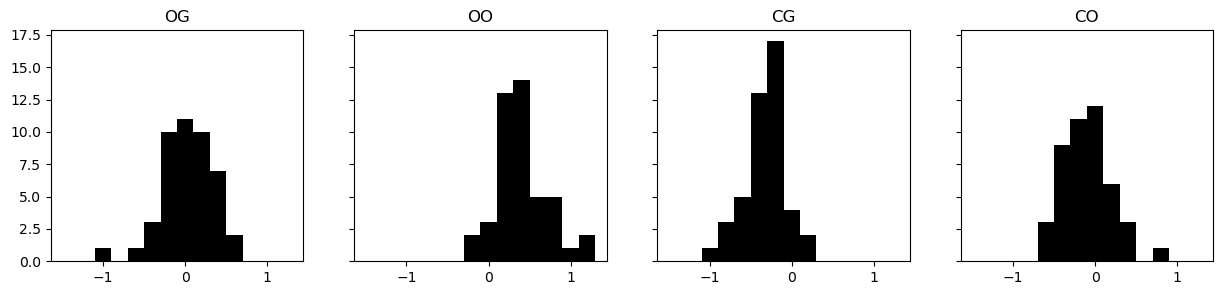

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 3), sharex=True, sharey=True)
bins = np.arange(-1.5, 1.5, 0.2)
for position, i in zip(positions, range(4)):
    ax[i].hist(full_df[position], bins=bins, color="black")
    ax[i].set_title(position)
plt.show()

In [7]:
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(pd.DataFrame({"mean": full_df[positions].mean(), "std": full_df[positions].std()}).T)

,OG,OO,CG,CO
mean,0.04,0.40,-0.34,-0.10
std,0.31,0.31,0.25,0.29


This confirms the long-held wisdom that it's good to be OO and bad to be CG, but it's interesting to see some numbers put on it: if OO and CG are equally matched, in the mean case CG has a 32% chance of beating OO. 

These numbers are good enough to serve as a starting point, but will need to be refined later. A big problem is that the logistic regression has been fit with regularisation, and the question is open of how much to regularise. This is especially thorny, given you can only pass one regularisation parameter, and the model estimates both team skill and motion balance in one go, and one might have different priors for the distributions of team skill and motion bias. If you change the regularisation parameter, you can get these numbers going up or down by about 15%, which is rather significant, but shows still that this is a decent enough estimation to get the whole thing started. 

# 4. Getting likelihoods

## 4.1 Naive likelihoods

Here my strategy was to calculate the likelihoods empirically, by running a very large number of simulated WUDCs. (I had a WUDC simulator lying about which I had made for my backtabbing project, and thought I might as well put it to work. Code can be found at [LINK].) To calculate $P(E=x|A=y)$, where $E$ is the estimated bias and $A$ is the actual bias, for a given position, I would simply get the simulations where the actual bias was $y$ and look at how the estimates were distributed. But first, for the simulations, I needed to decide on the value of a parameter, which is the standard deviation of team skill at the tournament - looking at various comparisons (e.g., what odds the 50th best team should have against the 10th best team, the 50th best team versus the median team, etc.) a standard deviation of 3 gave the most plausible probabilities. 

We can import the results of the simulations by running the following code. Two things to note:
1. Ignore everything there about dispersion measures,
2. The code takes 15 minutes or so to run. To save time you can just load the results from a file. 

In [95]:
posterior_bias_df = pd.read_csv("posterior_bias_save.txt", sep="\t")
# posterior_bias_df = pd.read_csv("likelihood_bias_save.txt", sep="\t")

def turn_sim_into_summary_df(num, C=1):
    """
    For a given simulation, return a df for the sim
    One row per round
    And each row contains:
    1. Actual bias for each position
    2. Estimates of bias for each position
    3. A number of measures of dispersion of estimated skill for that round
    """
    # Get actual bias
    actual_bias = posterior_bias_df.iloc[9 * (num):9 * (num + 1)].reset_index().drop("index", axis=1)

    
    # Import the file (HAVE TO CHANGE FILEPATH)
    split_df = pd.read_csv(f"posterior_sim_splits/output_{num}.txt", sep=" ")

    # Make predictors and responders
    block_a = pd.get_dummies(split_df["team_a"]).astype(int) - pd.get_dummies(split_df["team_b"]).astype(int)
    b_1 = pd.get_dummies(split_df["team_a_pos"] + split_df["round_num"].astype(str)).astype(int)
    b_2 = pd.get_dummies(split_df["team_b_pos"] + split_df["round_num"].astype(str)).astype(int)
    b1_aligned, b2_aligned = b_1.align(b_2, join='outer', axis=1, fill_value=0)
    block_b = b1_aligned - b2_aligned
    predictor_frame = pd.concat([block_a, block_b], axis=1).fillna(0) 
    # Necessary for if the team just does one round, e.g., swing team, sore losers
    responder_series = (split_df["team_a_rank"] < split_df["team_b_rank"]).astype(int)

    # Fit the model
    model = LogisticRegression(fit_intercept=False, penalty="l2", C=C)
    model.fit(predictor_frame, responder_series)
    coefficients = pd.Series(model.coef_[0], predictor_frame.columns)
    team_coefs = coefficients.iloc[:300]
    bias_coefs = coefficients.iloc[300:]

    # Get estimated bias
    est_bias = pd.DataFrame({
        "og_est": list(bias_coefs.iloc[18:27]),
        "oo_est": list(bias_coefs.iloc[27:36]),
        "cg_est": list(bias_coefs.iloc[0:9]),
        "co_est": list(bias_coefs.iloc[9:18])
    })

    
    # Add in the various dispersion measures
    # Start with some infrastructure, which is by round the draw and each split
    skill_dict = dict(zip(team_coefs.index, team_coefs))
    team_a_skills, team_b_skills = split_df["team_a"].map(skill_dict), split_df["team_b"].map(skill_dict)
    skill_splits = team_a_skills - team_b_skills
    round_skill_splits = {i: skill_splits[split_df["round_num"] == i] for i in range(1, 10)}
    room_skills = pd.DataFrame({
        "og": list(team_a_skills.iloc[::6]),
        "oo": list(team_b_skills.iloc[::6]),
        "cg": list(team_a_skills.iloc[5::6]),
        "co": list(team_b_skills.iloc[5::6])
    })
    round_room_skills = {i: room_skills.iloc[75 * (i - 1):75 * i] for i in range(1, 10)}

    # Get dispersion measures
    dispersion_df = pd.DataFrame()
    dispersion_df["inv_round_num"] = [1 / i for i in range(1, 10)]
    dispersion_df["room_stdev_by_round"] = [round_room_skills[i].std(axis=1).mean() for i in range(1, 10)]
    dispersion_df["mean_abs_skill_diff"] = [abs(round_skill_splits[i]).mean() for i in range(1, 10)]
    dispersion_df["mean_squ_skill_diff"] = [(round_skill_splits[i] ** 2).mean() for i in range(1, 10)]
    dispersion_df["one_minus_abs_diff"] = [1 / np.maximum(1 - abs(round_skill_splits[i]), 0).mean() 
                                            for i in range(1, 10)]
    dispersion_df["exp_minus_abs_diff"] = [1 / np.exp(-abs(round_skill_splits[i])).mean() for i in range(1, 10)]

    r_squared_stream = []
    for i in range(1, 10):
        responder = pd.concat([round_room_skills[i][pos] for pos in ["og", "oo", "cg", "co"]]).reset_index(drop=True)
        predictor = (pd.concat([round_room_skills[i].sum(axis=1)] * 4).reset_index(drop=True) - responder) / 3
        r_squared_stream.append(1 - predictor.corr(responder) ** 2)
    dispersion_df["room_rss_over_tss"] = r_squared_stream

    med = abs(skill_splits).median()
    dispersion_df["num_splits_over_med"] = [(abs(round_skill_splits[i]) > med).sum() for i in range(1, 10)]
    
    return pd.concat([actual_bias, est_bias, dispersion_df], axis=1)

In [96]:
# This is the cell that takes 15 minutes
dfs = []
start = time.time()
for i in range(10_000):
    print(f"Up to df {i}, elapsed {time.time() - start:.0f}s")
    dfs.append(turn_sim_into_summary_df(i, C=1))
long_df = pd.concat(dfs)
long_df.to_csv("data_prior_bias.txt", sep="\t", index=False)

Up to df 0, elapsed 0s
Up to df 1, elapsed 0s
Up to df 2, elapsed 0s
Up to df 3, elapsed 0s
Up to df 4, elapsed 0s
Up to df 5, elapsed 0s
Up to df 6, elapsed 0s
Up to df 7, elapsed 0s
Up to df 8, elapsed 0s
Up to df 9, elapsed 0s
Up to df 10, elapsed 1s
Up to df 11, elapsed 1s
Up to df 12, elapsed 1s
Up to df 13, elapsed 1s
Up to df 14, elapsed 1s
Up to df 15, elapsed 1s
Up to df 16, elapsed 1s
Up to df 17, elapsed 1s
Up to df 18, elapsed 1s
Up to df 19, elapsed 1s
Up to df 20, elapsed 1s
Up to df 21, elapsed 1s
Up to df 22, elapsed 1s
Up to df 23, elapsed 1s
Up to df 24, elapsed 1s
Up to df 25, elapsed 1s
Up to df 26, elapsed 2s
Up to df 27, elapsed 2s
Up to df 28, elapsed 2s
Up to df 29, elapsed 2s
Up to df 30, elapsed 2s
Up to df 31, elapsed 2s
Up to df 32, elapsed 2s
Up to df 33, elapsed 2s
Up to df 34, elapsed 2s
Up to df 35, elapsed 2s
Up to df 36, elapsed 2s
Up to df 37, elapsed 2s
Up to df 38, elapsed 2s
Up to df 39, elapsed 2s
Up to df 40, elapsed 3s
Up to df 41, elapsed 3s
Up

In [98]:
# Run this to save time
long_prior_summary_df = pd.read_csv("data_prior_bias.txt", sep="\t", index_col=0)

# Import another one, which has a much flatter distribution of actual bias.
# This is to check that results aren't highly specific to the simulations
# where bias is generated according to the priors, which might not be fully accurate.
long_unif_summary_df = pd.read_csv("data_flat_bias.txt", sep="\t", index_col=0)

Now we can finally have a look at how the estimated bias compares to the actual bias. Here, we can look at the distribution for when the bias for OG is actually about +0.4: 

Mean 0.323, stdev 0.135


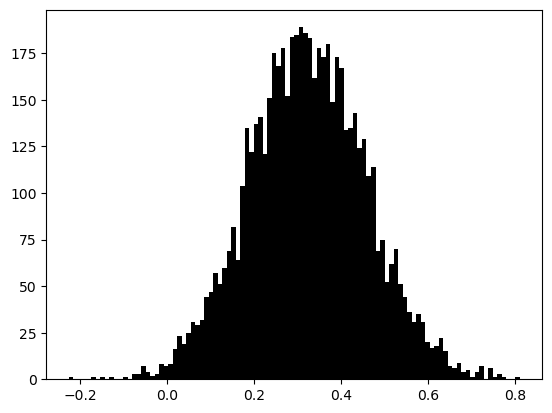

In [147]:
simulation = long_prior_summary_df

filtered = simulation[abs(simulation["og_act"] - (0.4)) < 0.05]["og_est"]
print(f"Mean {filtered.mean():.3f}, stdev {filtered.std():.3f}")
fig, ax = plt.subplots()
ax.hist(filtered, bins=100, color="black")
plt.show()

It looks normal, but one very striking feature is that the mean of the estimated bias (0.323) is significantly lower than the actual bias (0.4), a pattern which holds on both kinds of simulation. This holds in general: 

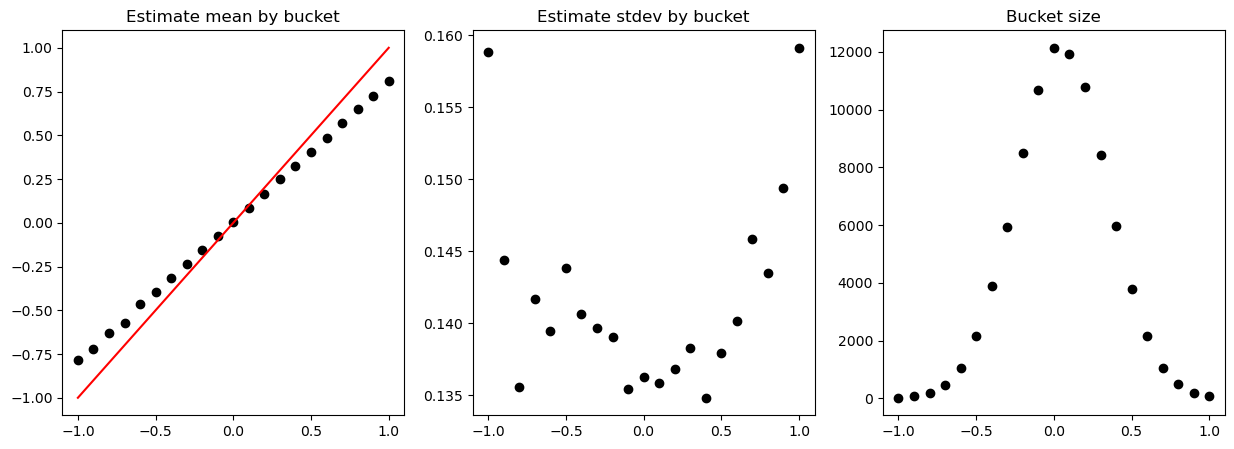

In [100]:
# Graph mean and stdev against actual
position = "og"
simulation = long_prior_summary_df

rows = []
for xtick in np.arange(-1, 1.001, 0.1):
    filtered = simulation[
        abs(simulation[f"{position}_act"] - xtick) < 0.05
    ][f"{position}_est"]
    rows.append([xtick, filtered.mean(), filtered.std(), len(filtered)])
summary_df = pd.DataFrame(rows, columns=["actual_mean", "estimate_mean", "estimate_stdev", "samples"])

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
ax[0].scatter(summary_df["actual_mean"], summary_df["estimate_mean"], color="black")
ax[0].plot([-1, 1], [-1, 1], color="red")
ax[0].set_title("Estimate mean by bucket")
ax[1].scatter(summary_df["actual_mean"], summary_df["estimate_stdev"], color="black")
ax[1].set_title("Estimate stdev by bucket")
ax[2].scatter(summary_df["actual_mean"], summary_df["samples"], color="black")
ax[2].set_title("Bucket size")
plt.show()

We can make this more precise: 

In [31]:
pred, targ = summary_df["actual_mean"], summary_df["estimate_mean"]
beta = (pred * targ).sum() / (pred ** 2).sum()
beta

0.8012843210267813

The expected value of the estimated bias is almost exactly four fifths of the actual bias, and the standard deviation of this distribution can be approximated to be 0.14. The estimates being biased towards 0 has an obvious explanation, which is that the logistic regression is regularising a little bit too aggressively, but the adjustment of multiplying by 1.25 can take care of that anyway. However, this is not the whole story. 

## 4.2 Thinking about dispersion

Really, in some situations you will have more information about motion bias than others. Specifically, in early rounds teams are randomly drawn and so there is a lot of mismatch, which means that an early round's results might not be particularly sensitive to motion bias. A split between a team on +2 skill and a team on -2 skill probably won't tell you much about whether a motion's bias is +0.1 or +0.2 in favour of the former team, because the difference there is between the worse team having a 1.6% versus a 1.5% chance of winning. However, if the teams are equally matched, the difference between a motion's being +0.1 and +0.2 biased is between a 47.5% and 45.0% chance of winning. 

This means that a round of 75 debates has a lower effective sample size when the teams are very unevenly matched. So in that case, the likelihood should have a higher standard deviation to reflect that we have less information in our sample. One thing, then, that could improve predictive accuracy is having the likelihood also take into account effective sample size. 

However, one could think that this isn't a problem for the following reason: the logistic regression I am using has a prior, so if the data I am feeding into it isn't very informative, it won't move the estimates much, so this model already accounts for the lower effective sample size. But I doubt this, because uninformative debating-round data is very noisy, and so there is still a serious risk of overfit. 

So, before going on, I would expect that for cases where teams are very mismatched there is a lower effective sample size, and so the likelihood distribution should have a higher standard deviation. However, maybe in cases where teams are very closely matched, standard deviation should be slightly higher in cases where the motion is very biased. To illustrate with an extreme case, if the motion favours some positions by skill 10 over others, then the ideal room composition to test this would be to have as many splits as possible be between teams with a skill difference of about 10, because if the skill difference is 0 it will only be able to say that a position is favoured by the motion but not by how much. Although that applies in very extreme cases, I am not sure if it will show up in the actual or simulated data. 

Round 1 beta: 0.720
Round 9 beta: 0.825


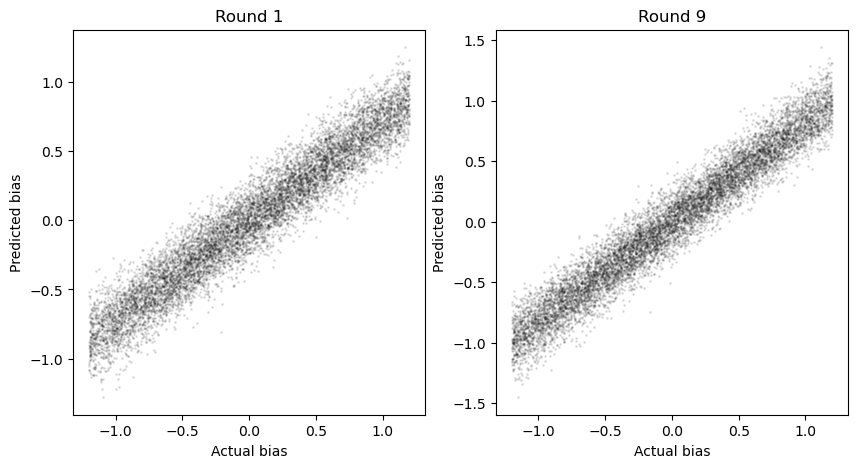

In [64]:
position = "oo"
simulation = long_unif_summary_df
rounds = [1, 9]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
for i in range(2):
    round_df = simulation[simulation["round"] == rounds[i]]
    pred, targ = round_df[f"{position}_act"], round_df[f"{position}_est"]
    ax[i].scatter(pred, targ, s=1, color="black", alpha=0.1)
    ax[i].set_title(f"Round {rounds[i]}")
    ax[i].set_xlabel("Actual bias")
    ax[i].set_ylabel("Predicted bias")
    beta = (pred * targ).sum() / (pred ** 2).sum()
    print(f"Round {rounds[i]} beta: {beta:.3f}")
plt.show()

Taking it for granted that round 9 has more evenly matched teams than round 1 (for each round, teams are put against those on the same/a similar number of points), two things become clear. First, the beta is higher for when teams are evenly matched. This makes a lot of sense: if teams are more evenly matched, you get more information out of the round's results, which means that the prior of the logistic regression (which pulls the estimate towards 0) is weighted less heavily. Second, the dots in the second scatter plot is more tightly clustered, i.e., there is less noise. That also makes plenty of sense: if you have more information from the round, your estimates are going to be closer to the actual value, i.e., there will be less noise. 

Moving forward, it seems that round number is not an ideal measure of effective sample size, or at least it isn't obviously the best one. So I will try a few others. 

## 4.3 Trying different measures of dispersion

It's unclear exactly how to measure the effective sample size of a given round. So I have come up with some different ways to measure how dispersed or concentrated team skill is in a round (higher numbers mean more dispersed):
1. $\frac{1}{\text{round\_num}}$: this is a control measure, the higher the round number the less dispersed teams are.
2. Take the standard deviation of the estimated skill of the teams in a room, and average that over all the rooms. The reason I do estimated skill, rather than actual skill, is because the latter quantity is inaccessible, so we have to settle for the former.
3. Take every split in the round, take the absolute difference between the two teams' estimated skill, and average that over all splits.
4. Take every split in the round, take the square of the difference between the two teams' estimated skill, and average that over all splits.
5. Approximate the informativeness of a given split with $\max(1 - \text{diff}, 0)$, that is, a split is 100% informative if the teams are evenly matched, down to 0% informative if their estimated skill differs by 1 or more. Take the mean of that across the rooms, and get the reciprocal so it increases with how dispersed teams are. 
6. Do the same as (5) but with the informativeness of a given split being $e^{-\text{diff}}$. 
7. This is to get a rough measure of how well one can predict a team's (estimated) skill using that of their opponents for that round. For each team, take the average of their opponents' estimated skill, and take the correlation of those two quantities over all teams. Calculate the r-squared, and, to make that higher if teams are more dispersed, subtract that from 1.
8. Count the median (unsigned) skill difference over the whole competition. The dispersion for a round is how many splits have a larger skill difference than that median.

As much as I can sit back and think which one of these is the best measure (I anticipate 5 or 6, since they do the best job of counting up the effective sample size), it's probably best to test them because I don't have strong beliefs either way. Let's start by seeing if they are very different at all: 

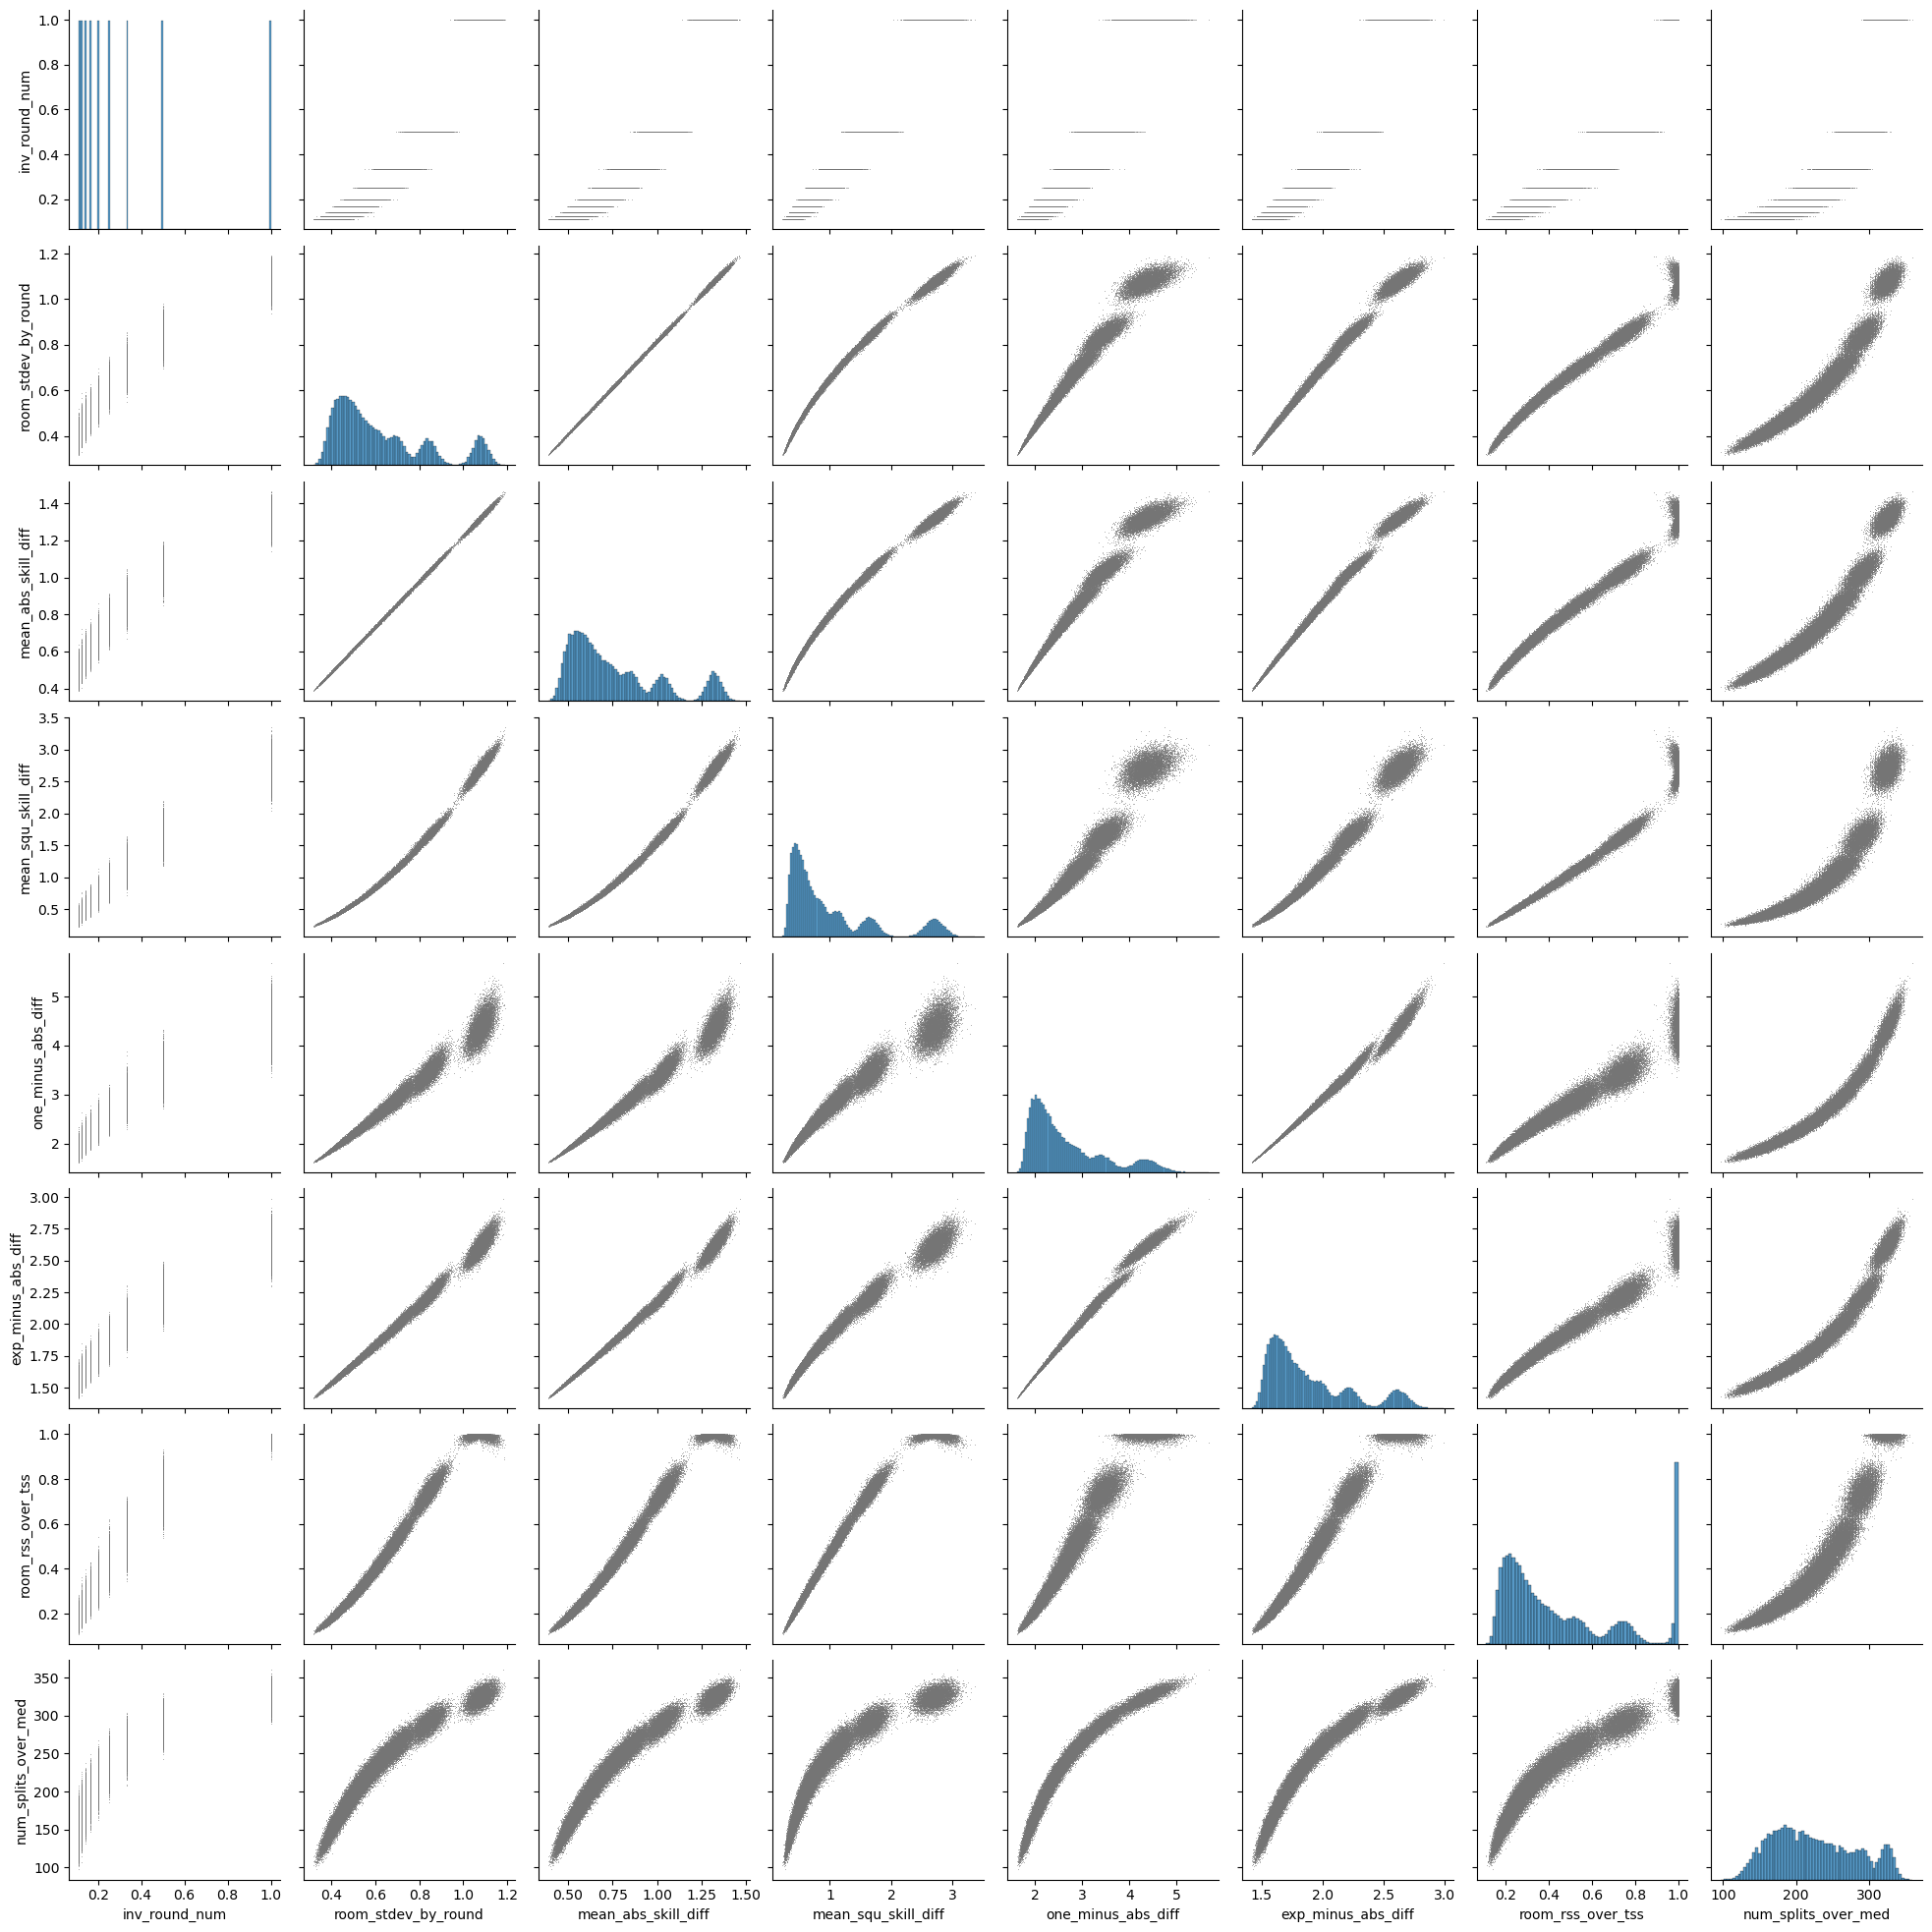

In [67]:
simulation = long_prior_summary_df

measures = [
    "inv_round_num",
    "room_stdev_by_round",
    "mean_abs_skill_diff",
    "mean_squ_skill_diff",
    "one_minus_abs_diff",
    "exp_minus_abs_diff",
    "room_rss_over_tss",
    "num_splits_over_med"
]
sns.pairplot(simulation[measures], plot_kws={'marker': '.', 'color': 'black', 's': 1})
plt.show()

So these measures generally agree on which rounds are more dispersed than others, but not entirely. 

Below you can see that round number is a decent proxy for dispersion, however there are. many cases where, say, a round 8 is more dispersed than a round 6. (I mostly include this graph because it is pretty.) 

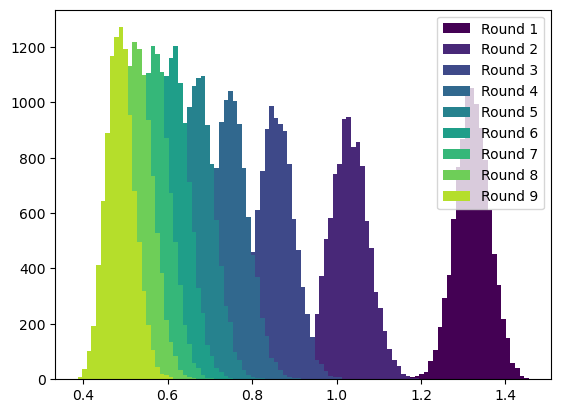

In [62]:
simulation = long_prior_summary_df
measure = "mean_abs_skill_diff"

fig, ax = plt.subplots()
for i in range(1, 10):
    ax.hist(
        simulation[simulation["round"] == i][measure], 
        bins=np.arange(
            simulation[measure].min(), 
            simulation[measure].max(), 
            (simulation[measure].max() - simulation[measure].min()) / 100
        ), 
        color=cm.viridis((i - 1) / 9)
    )
ax.legend([f"Round {i}" for i in range(1, 10)])
plt.show()

## 4.4 See how betas and stdev vary with dispersion

In [102]:
def get_beta_or_stdev_by_bucket(measure, num_buckets, plot, rolling_avg, simulation):
    long_copy = simulation.copy()#.iloc[:len(long_df) // 2]
    long_copy["dispersion_bucket"] = pd.qcut(
        long_copy[f"{measure}"], 
        q=num_buckets, 
        labels=range(1, num_buckets + 1), 
        duplicates='drop'
    )

    betas = {"og": [], "oo": [], "cg": [], "co": []}
    stdevs = {"og": [], "oo": [], "cg": [], "co": []}
    for bucket_num in range(1, num_buckets + 1):
        bucket = long_copy[abs(long_copy["dispersion_bucket"].astype(int) - bucket_num) < 1]
        for position in betas.keys():
            pred = bucket[f"{position}_act"]
            targ = bucket[f"{position}_est"]
            beta = (pred * targ).sum() / (pred ** 2).sum()
            betas[position].append(beta)
            train_beta = ((pred.iloc[:len(pred)//2] * targ.iloc[:len(pred)//2]).sum()
                          / (pred.iloc[:len(pred)//2] ** 2).sum())
            residuals = targ.iloc[len(pred)//2:] / train_beta - pred.iloc[len(pred)//2:]
            stdev = residuals.std()
            stdevs[position].append(stdev)
        # fig, ax = plt.subplots()
        # ax.scatter(pred, residuals, s=1, color="black")
        # ax.hist(residuals, bins=30, color="black")
        # assert False

    if plot == "betas":
        rel_dict = betas
    elif plot == "stdevs":
        rel_dict = stdevs
    else:
        print("Argument 'plot' entered incorrectly")
        return

    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 4), tight_layout=True, sharey=True)
    for position, i in zip(rel_dict.keys(), range(4)):
        xticks = long_copy.groupby("dispersion_bucket", observed=True)[measure].mean()
        rel_series = pd.Series(rel_dict[position])
        ax[i].scatter(xticks, rel_series, s=10, color="black")
        if rolling_avg:
            rolling_mean = ((rel_series.cumsum() - rel_series.cumsum().shift(4)) / 4).shift(-2)
            ax[i].plot(xticks, rolling_mean, color="red")
        ax[i].set_title(f"{measure}; {position}")
        ax[i].set_xlabel(measure)
        ax[i].set_ylabel(plot)
    plt.show()

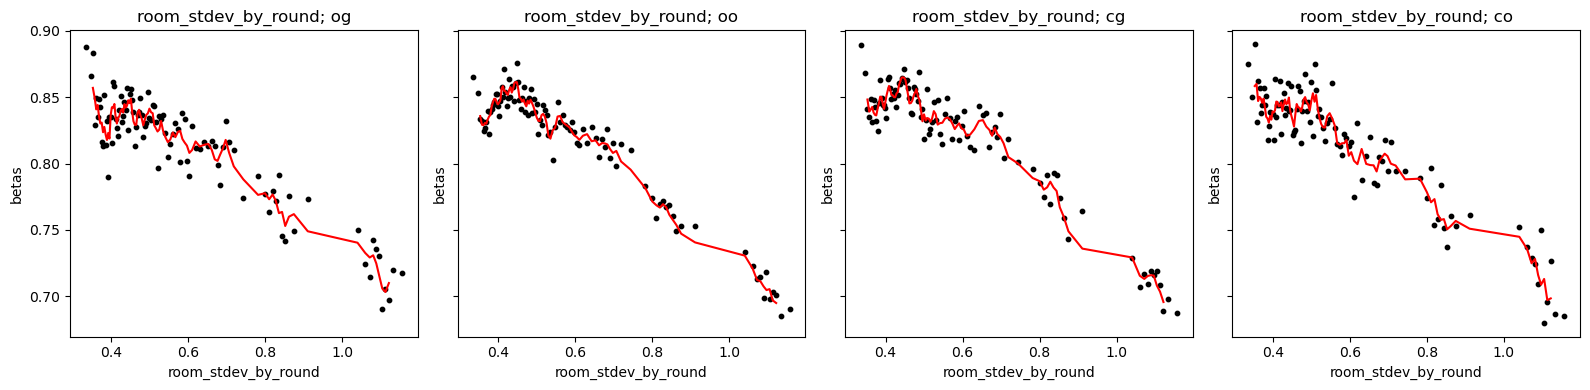

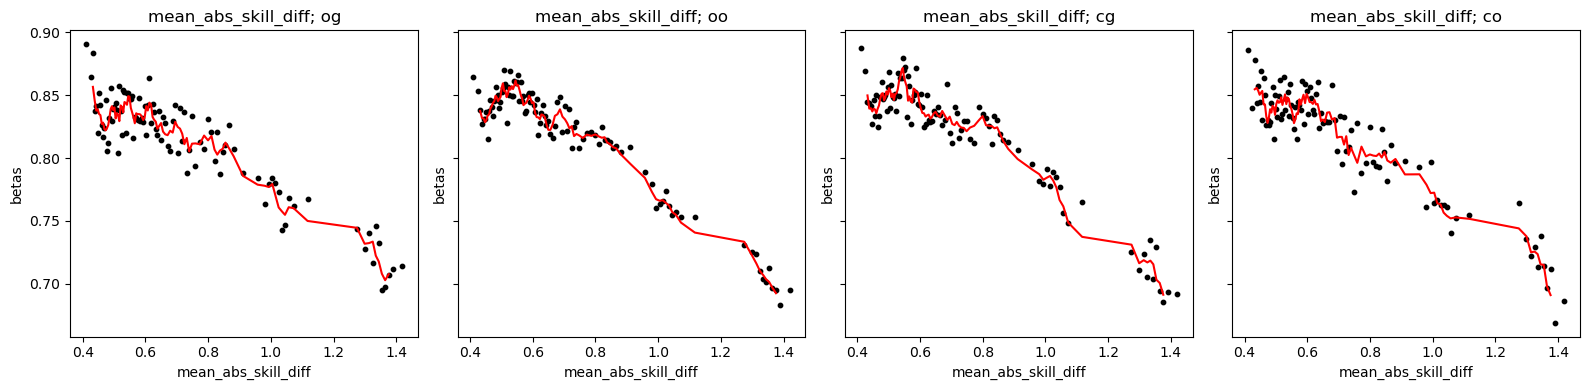

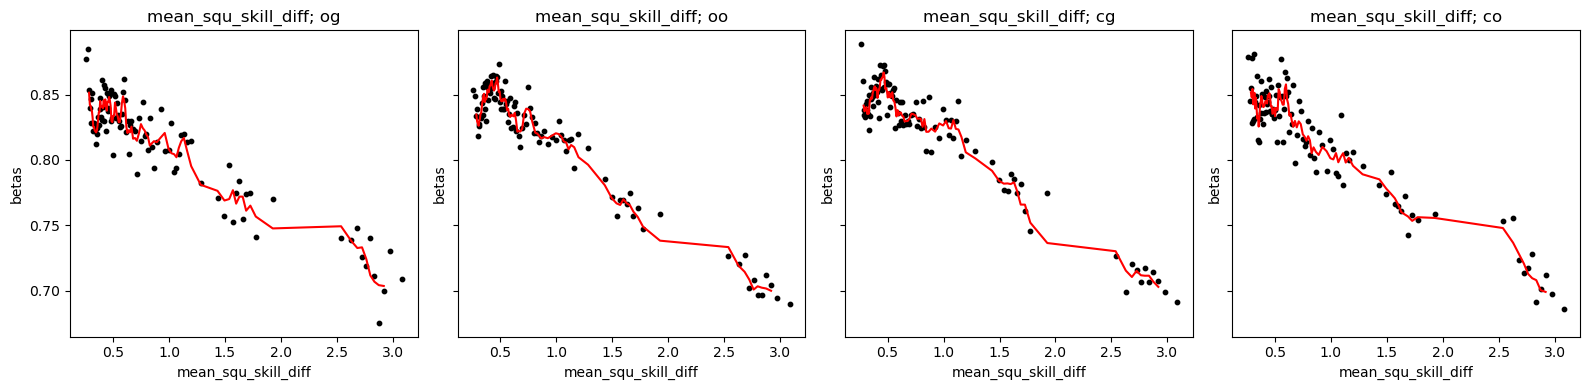

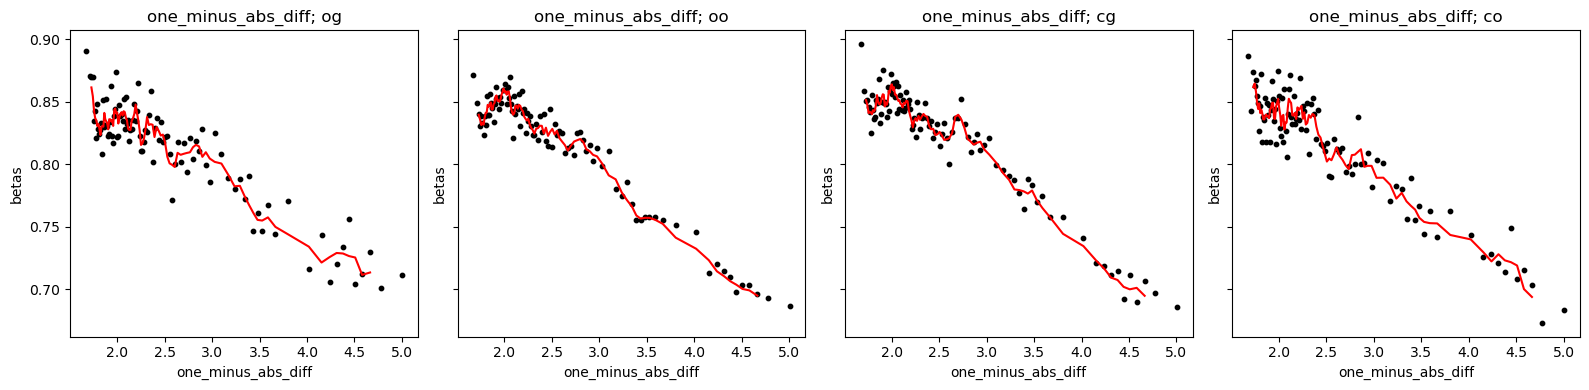

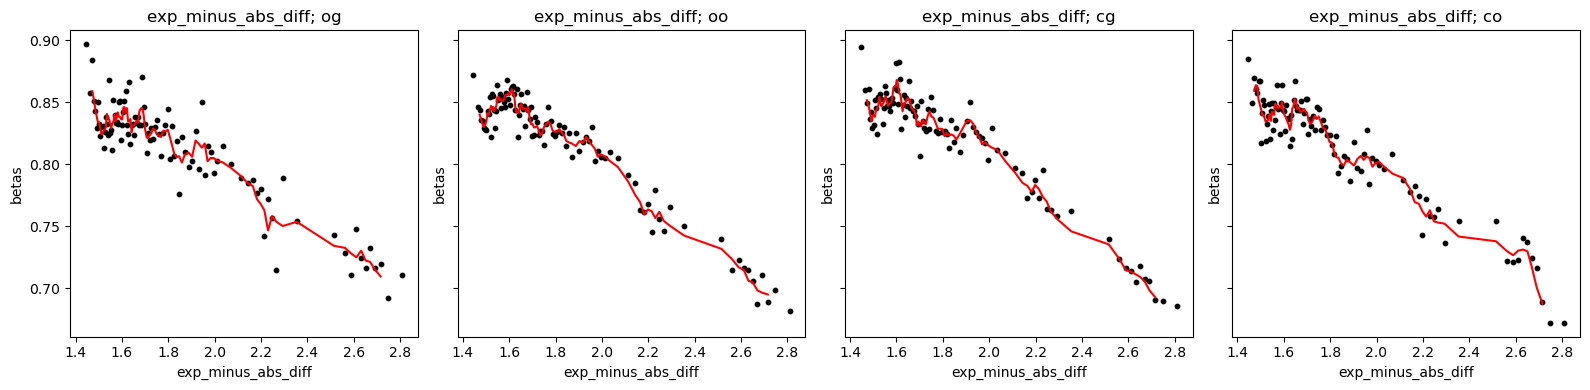

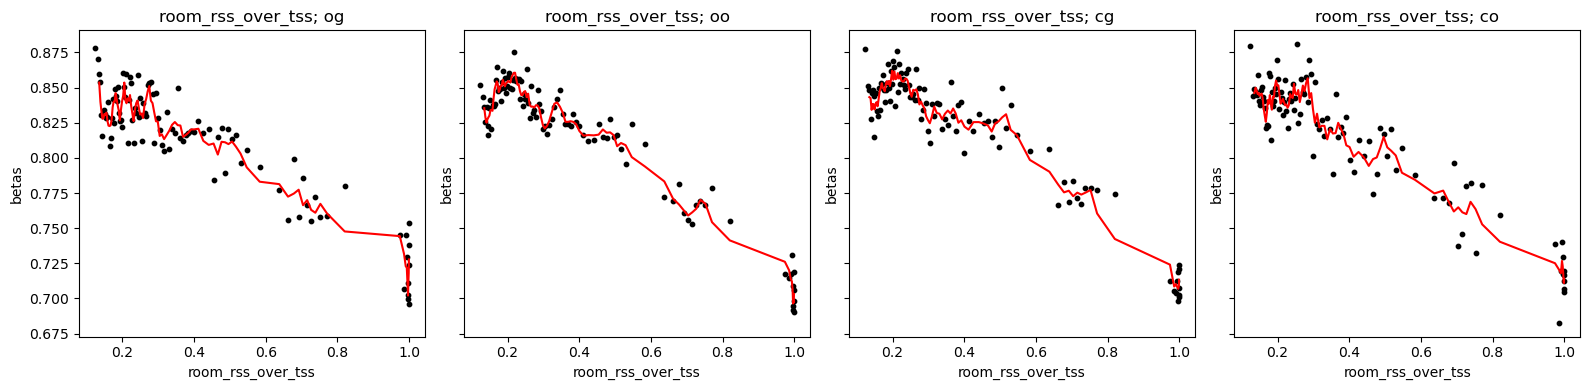

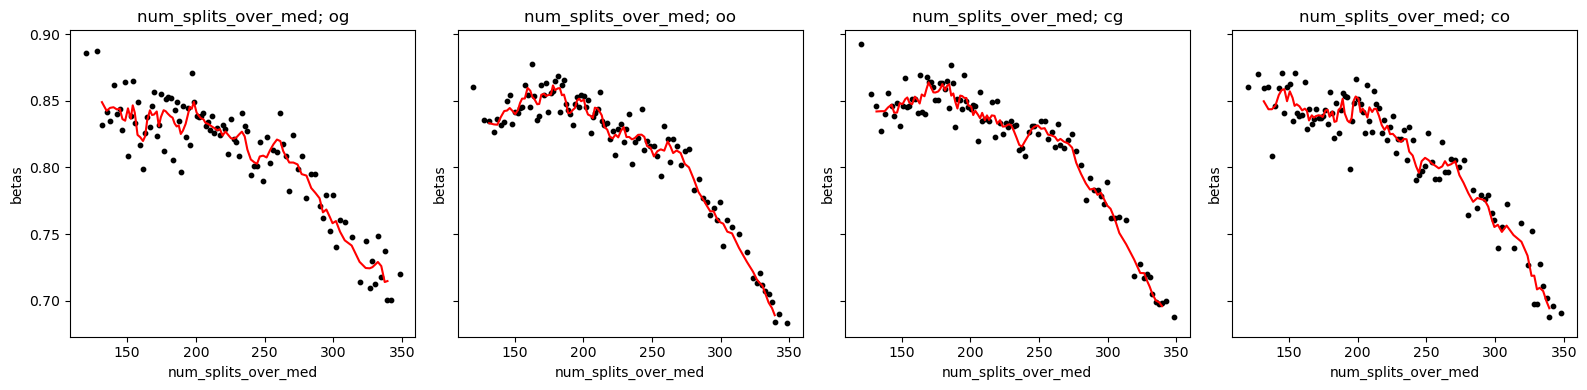

In [108]:
simulation = long_prior_summary_df

for measure in measures:
    if measure == "inv_round_num": continue # Get problem if bins > 9
    get_beta_or_stdev_by_bucket(measure, 100, "betas", True, simulation)

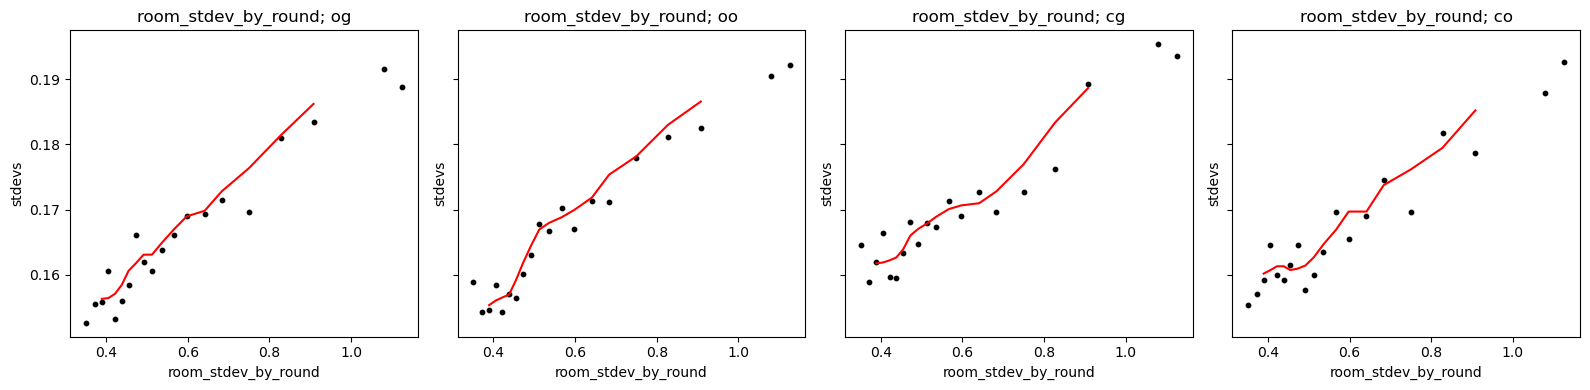

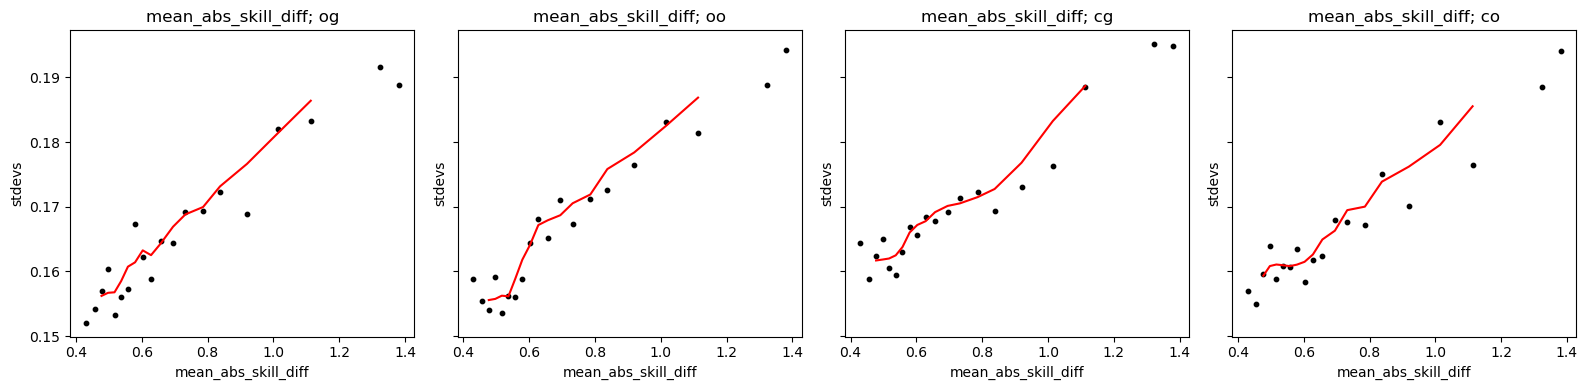

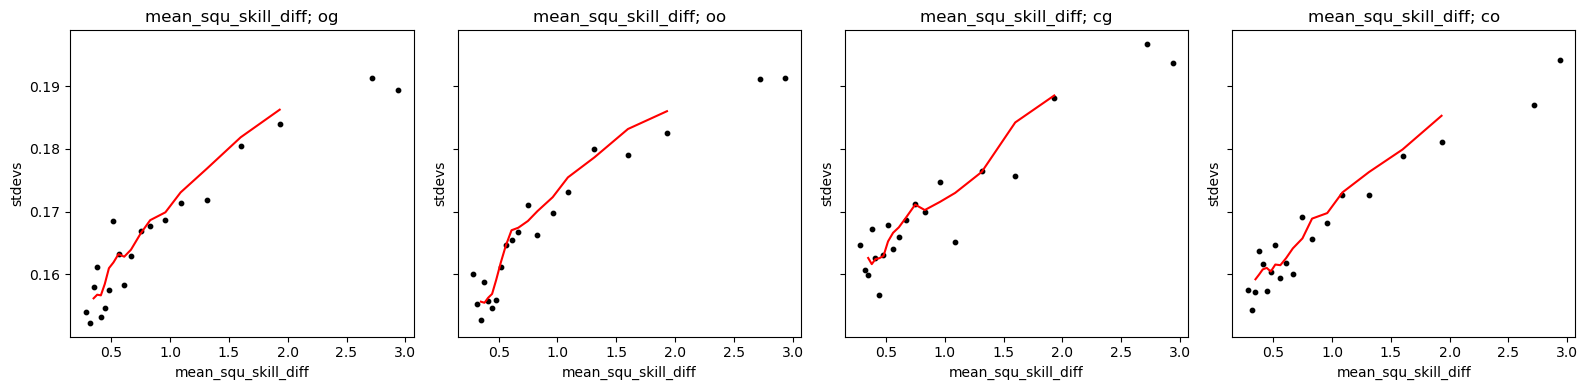

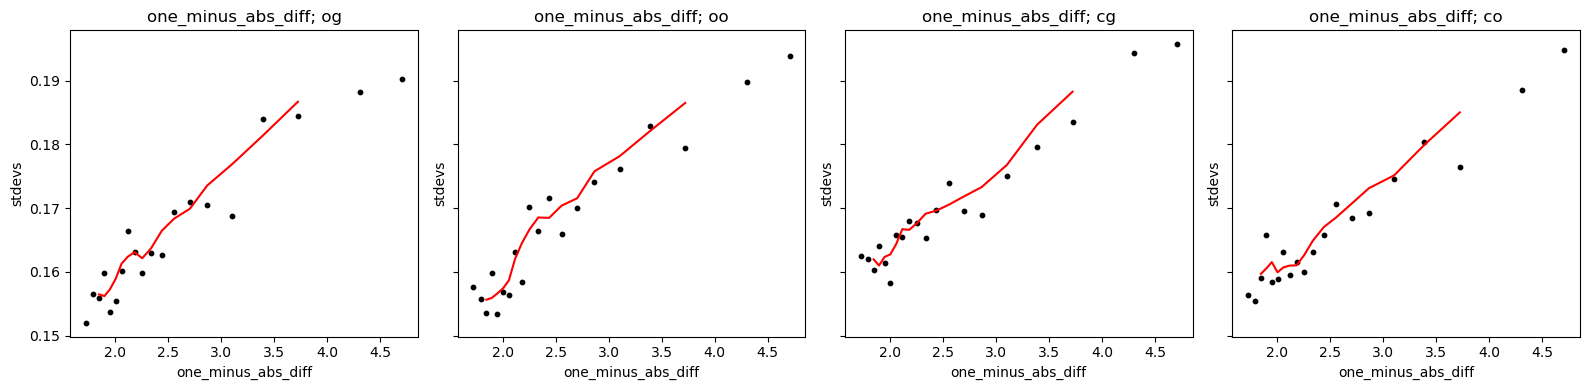

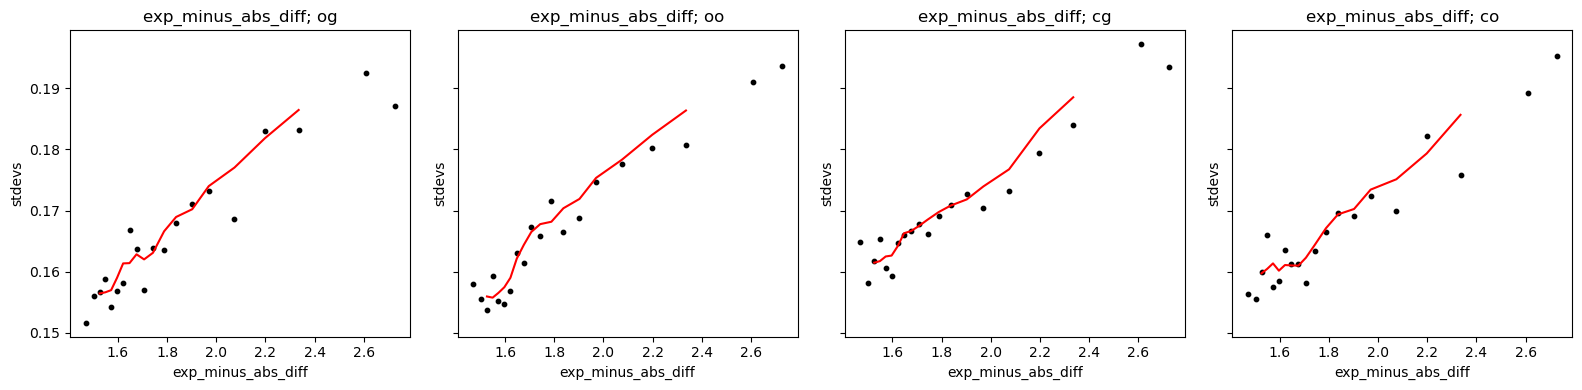

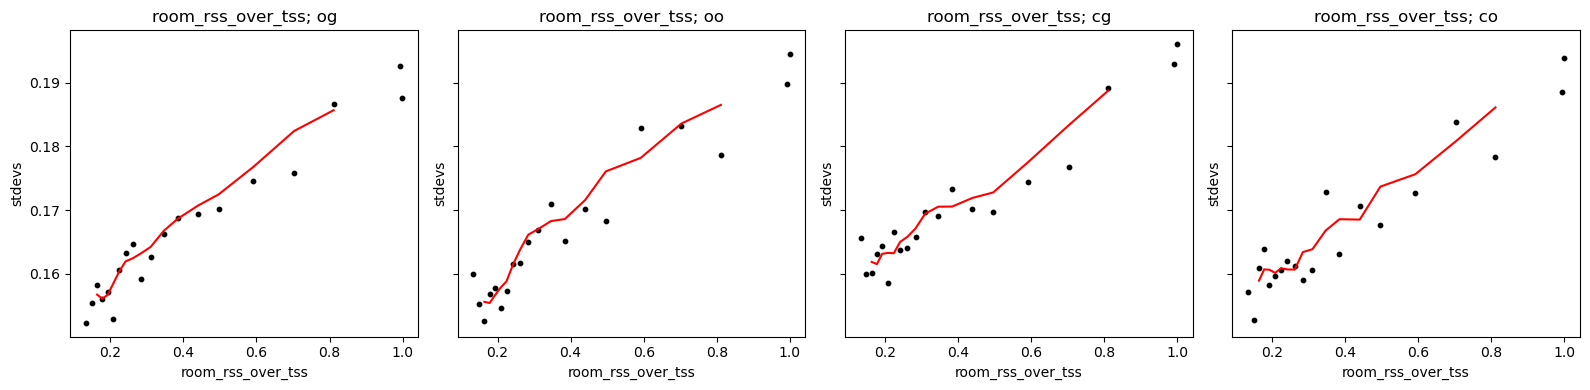

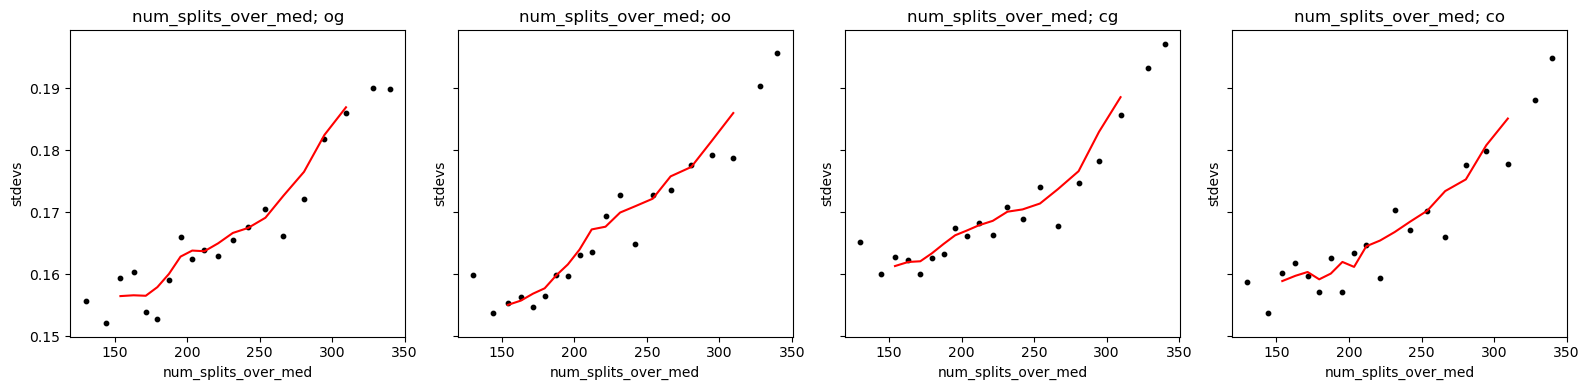

In [109]:
simulation = long_prior_summary_df

for measure in measures:
    if measure == "inv_round_num": continue # Get problem if bins > 9
    get_beta_or_stdev_by_bucket(measure, 20, "stdevs", True, simulation)

A few things to notice here:

For the betas from actual bias to estimated bias, they get lower as dispersion increases. That is, given the actual bias of the motion, if teams are more dispersed, you expect to see the estimate of bias undershoot the actual bias by more. This would be because the lower effective sample size means that the prior is too strong, and so the signal needs to be boosted afterwards by more. It's not an elegant solution, but it works. 

The stdevs tend to increase as dispersion increases. A note on how I calculated the stdevs: I did this by calculating a beta for the first half of the simulations, then testing it on the second half of the simulation and getting the standard deviation of the residuals, to avoid having a lower-than-appropriate estimate from overfitting (as unlikely as that might be given a one-variable linear model). The reason I do $\text{target} / \beta - \text{predictor}$, rather than $\text{target} - \beta \cdot \text{predictor}$, can be seen in an extreme case. Suppose $\beta = 0.001$ as a result of a much-too-strong prior. Then, if the actual bias is, say, 0.5, all of the estimates are going to be crowded around 0.0005 with a tiny standard deviation. What gives a better idea of how the likelihood will look is scaling up those estimates so that their mean is equal to the actual bias, and then taking the standard deviation. Doing this on the naive method at the start gives a standard deviation of 0.17. Digression over, what we see is that the more dispersed teams are, the more varied the estimates are (post-rescaling). This is because higher dispersion means less information, which means more noise. 

## 4.5 Choosing a prior for the logistic regression, and a measure for dispersion

All of the betas in the above section are less than 1, which suggests that underfitting is rather systematic. Surely a better approach would be to have a less strong prior for the logistic regression? But I tried a number of values for this, and compared how they performed in reducing the stdevs as calculated above (noting that without that adjustment, very aggressive priors would have a very low stdev). The idea was that the best prior would have the lowest stdevs, but a very wide range of them (normal with stdevs from 0.1 to 1000) had results that were basically the same. So I settled on a stdev of 1, which had very marginally better results than the others. 

For the measure of dispersion, I wanted to choose the measure that best divided the simulations into lower- and higher-standard deviation buckets. However, they all performed basically the same, so I decided to go with option (3), of taking the mean of the absolute difference of the team skills in each split. This is because, given roughly identical performance (and there being so much data that priors don't matter that much, in the scheme of things), it is very easy to implement. 

## 4.6 Brief intermission: checking the relationship between actual bias and expected estimated bias is linear

The above has assumed that, for a given level of dispersion, the relationship between actual bias and expected estimated bias is linear. This is not immediately obvious, so before moving on we had better check this. 

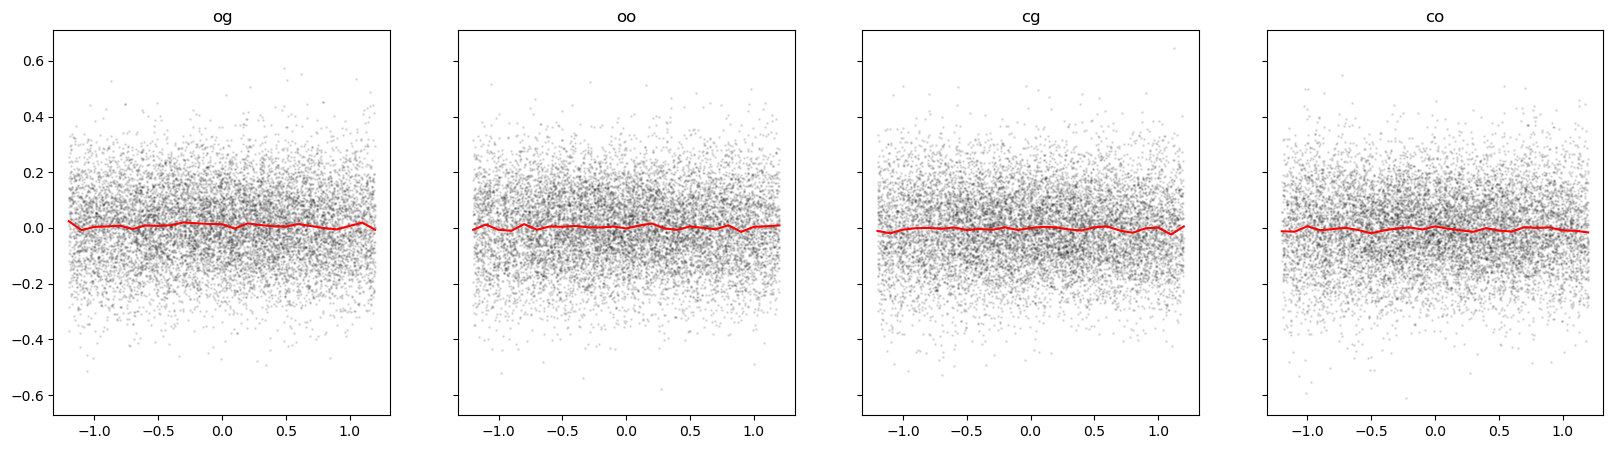

In [112]:
dispersion = 0.6
simulation = long_unif_summary_df

trim_frame = simulation[abs(simulation["mean_abs_skill_diff"] - dispersion) < 0.025]
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5), sharex=True, sharey=True)
for pos, i in zip(["og", "oo", "cg", "co"], range(4)):
    pred, targ = trim_frame[f"{pos}_act"], trim_frame[f"{pos}_est"]
    beta = (pred * targ).sum() / (pred ** 2).sum()
    residuals = targ - beta * pred
    ax[i].scatter(pred, residuals, s=1, color="black", alpha=0.1)
    ax[i].set_title(pos)
    xticks = np.arange(-1.5, 1.5, 0.1)
    yticks = [residuals[abs(pred - xtick) < 0.05].mean() for xtick in xticks]
    ax[i].plot(xticks, yticks, color="red")
plt.show()

The residuals (black) don't seem to have their variance depend on the actual bias, and the rolling mean of the residuals (in red) is just a flat line. So there is no evidence that the relationship is not linear. And while we're at it, let's check that the residuals are normally distributed. Taking a slide from all of these at random, say, actual=0.5, we can have a look at the residuals of each:

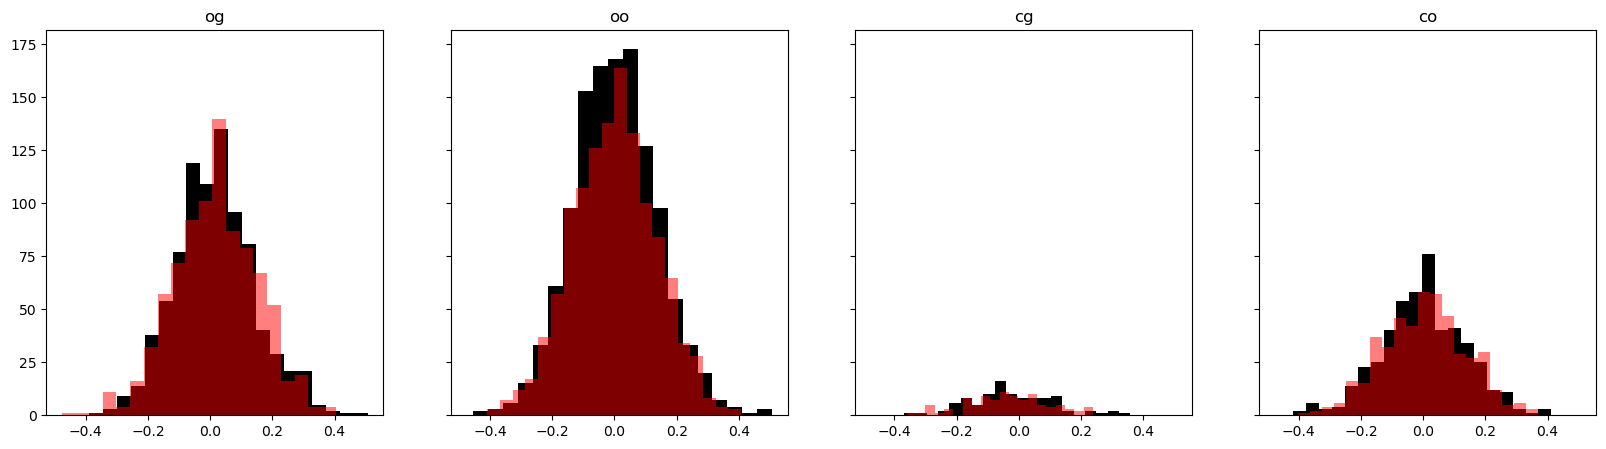

In [113]:
dispersion = 0.6
actual = 0.3
simulation = long_prior_summary_df

trim_frame = long_df[abs(long_df["mean_abs_skill_diff"] - dispersion) < 0.025]
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5), sharex=True, sharey=True)
for pos, i in zip(["og", "oo", "cg", "co"], range(4)):
    pred, targ = trim_frame[f"{pos}_act"], trim_frame[f"{pos}_est"]
    beta = (pred * targ).sum() / (pred ** 2).sum()
    residuals = targ - beta * pred
    selected_residuals = residuals[abs(pred - actual) < 0.05]
    ax[i].hist(selected_residuals, bins=20, color="black")
    simulated = np.random.normal(
        selected_residuals.mean(),
        selected_residuals.std(),
        len(selected_residuals)
    )
    ax[i].hist(simulated, bins=20, color="red", alpha=0.5)
    ax[i].set_title(pos)
plt.show()

It's not perfect, but it there's not close to enough evidence to overturn the default assumption that the residuals are normal. 

## 4.7 Fit curves to the betas and the stdevs

In [114]:
def get_stdevs_and_betas(measure, num_buckets, big_df):
    long_copy = big_df.copy()#.iloc[:len(long_df) // 2]
    long_copy["dispersion_bucket"] = pd.qcut(
        long_copy[f"{measure}"], 
        q=num_buckets, 
        labels=range(1, num_buckets + 1), 
        duplicates='drop'
    )

    betas = {"og": [], "oo": [], "cg": [], "co": []}
    stdevs = {"og": [], "oo": [], "cg": [], "co": []}
    for bucket_num in range(1, num_buckets + 1):
        bucket = long_copy[abs(long_copy["dispersion_bucket"].astype(int) - bucket_num) < 1]
        for position in betas.keys():
            pred = bucket[f"{position}_act"]
            targ = bucket[f"{position}_est"]
            beta = (pred * targ).sum() / (pred ** 2).sum()
            betas[position].append(beta)
            train_beta = ((pred.iloc[:len(pred)//2] * targ.iloc[:len(pred)//2]).sum()
                          / (pred.iloc[:len(pred)//2] ** 2).sum())
            residuals = targ.iloc[len(pred)//2:] / train_beta - pred.iloc[len(pred)//2:]
            stdev = residuals.std()
            stdevs[position].append(stdev)

    xticks = long_copy.groupby("dispersion_bucket", observed=True)[measure].mean()

    return xticks, betas, stdevs

In [316]:
def get_beta_prediction(xtick, position):
    if position in ["og", "co"]:
        return 0.84 if xtick < 0.63 else 0.95 - 0.18 * xtick
    else:
        return 0.9 - 0.1 * xtick if xtick < 0.85 else 0.98 - 0.2 * xtick

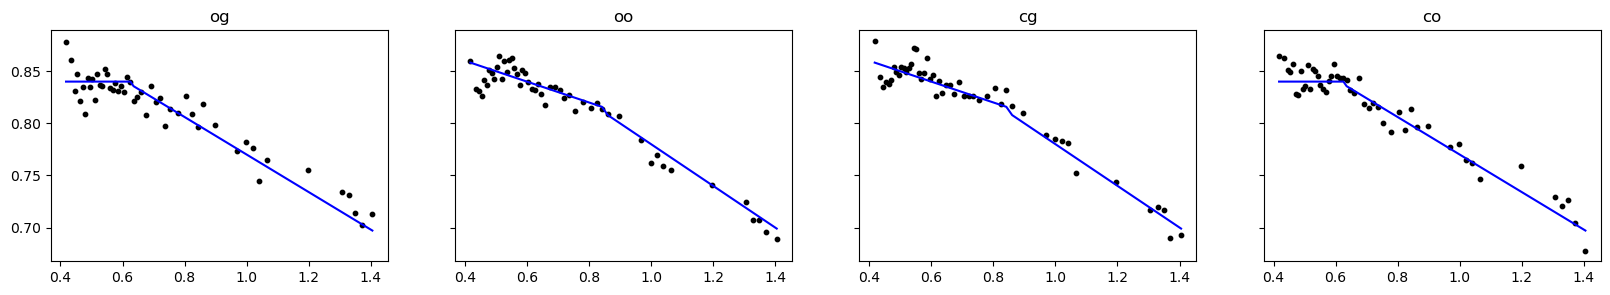

In [317]:
simulation = long_prior_summary_df

xticks, betas, stdevs = get_stdevs_and_betas("mean_abs_skill_diff", 50, long_df)
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 3), sharex=True, sharey=True)
for pos, i in zip(["og", "oo", "cg", "co"], range(4)):
    ax[i].scatter(xticks, betas[pos], s=10, color="black")
    prediction = [get_beta_prediction(xtick, pos) for xtick in xticks]
    ax[i].plot(xticks, prediction, color="blue")
    ax[i].set_title(pos)
plt.show()

This isn't very beautiful, but it's a good enough fit and there's good reason to suspect this isn't badly overfit:
1. There aren't many parameters: I divided into two families (oo and cg are alike in that they are more biased than other positions on average), and in each family there are only four parameters with three degrees of freedom, because the curve has to be continuous.
2. I have done some checking by varying the sample, e.g., changing the number of buckets, and choosing random subsets of the full dataset, and it all looks very similar. 

In [313]:
def get_stdev_prediction(xtick):
    return 0.135 + 0.045 * xtick

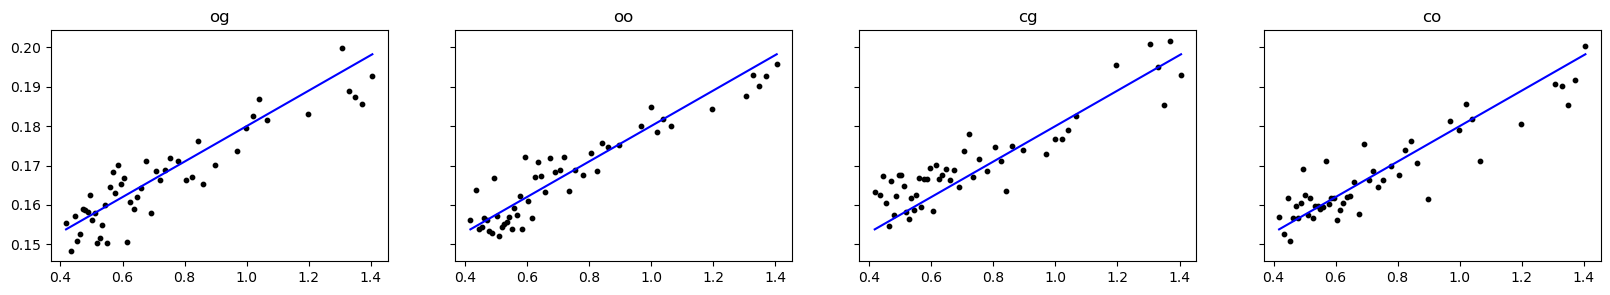

In [314]:
simulation = long_prior_summary_df

xticks, betas, stdevs = get_stdevs_and_betas("mean_abs_skill_diff", 50, simulation)
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 3), sharex=True, sharey=True)
for pos, i in zip(["og", "oo", "cg", "co"], range(4)):
    ax[i].scatter(xticks, stdevs[pos], s=10, color="black")
    prediction = [get_stdev_prediction(xtick) for xtick in xticks]
    ax[i].plot(xticks, prediction, color="blue")
    ax[i].set_title(pos)
plt.show()

Again, not too beautiful, but it's the best we can do with this data, and it fits well enough on a range of subsets and bucket numbers.

## 4.8 Get likelihoods

In [281]:
def get_likelihood_mean_and_stdev(position, actual, dispersion):
    """
    Gives you the mean and stdev of the likelihood
    """
    beta = get_beta_prediction(dispersion, position)
    mean = beta * actual
    stdev = get_stdev_prediction(dispersion) * beta # This undoes the previous adjustment
    return mean, stdev

Now to check how this stacks up against the simulations:

Position: co
Num samples: 308
Full sim mean: 0.588
Full sim stdev: 0.138
Calculated mean: 0.587
Calculated stdev: 0.138


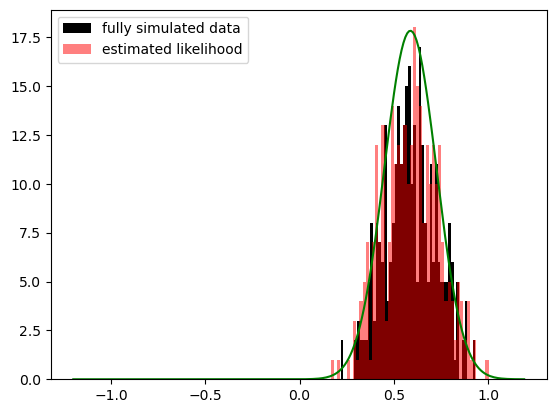

In [319]:
simulation = long_unif_summary_df
position = random.choice(positions).lower()
actual_bias = random.uniform(-1, 1)
dispersion = random.uniform(0.4, 1.4)

actual = simulation[
    (abs(simulation[f"{position}_act"] - actual_bias) < 0.05)
    & (abs(simulation["mean_abs_skill_diff"] - dispersion) < 0.04)
][f"{position}_est"]
print(f"Position: {position}")
print(f"Num samples: {len(actual)}")
print(f"Full sim mean: {actual.mean():.3f}")
print(f"Full sim stdev: {actual.std():.3f}")

mean, stdev = get_likelihood_mean_and_stdev(position, actual_bias, dispersion)
calc_likelihood = np.random.normal(mean, stdev, len(actual))
print(f"Calculated mean: {mean:.3f}")
print(f"Calculated stdev: {stdev:.3f}")

xticks = np.round(np.arange(-1.2, 1.2, 0.01), decimals=2)
yticks = (1 / (2 * np.pi * stdev ** 2) ** 0.5) * np.exp(-(xticks - mean) ** 2 / (2 * stdev ** 2))

fig, ax = plt.subplots()
ax.hist(actual, bins=50, color="black")
ax.hist(calc_likelihood, bins=50, color="red", alpha=0.5)
ax.legend(["fully simulated data", "estimated likelihood"])
ax.plot(xticks, yticks * len(actual) / 50, color="green")
plt.show()

These aren't perfect, but they tend to be accurate to about 0.01, which is not so bad. The difference between a motion that favours a team by 0 and one that favours a team by 0.01 is the difference between that team having a 50% chance of beating an equally matched team versus a 50.25% chance, which isn't so large. And compare it to before there was any accounting for dispersion: 

Num samples: 1605
Full sim mean: -0.297
Full sim stdev: 0.145
Calculated mean: -0.288
Calculated stdev: 0.135


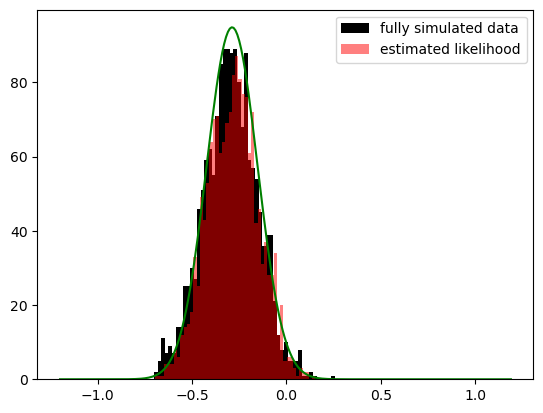

In [213]:
simulation = long_prior_summary_df
position = random.choice(positions).lower()
actual_bias = random.uniform(-1, 1)
dispersion = random.uniform(0.4, 1.4)

actual = simulation[
    (abs(simulation[f"{position}_act"] - actual_bias) < 0.05)
    & (abs(simulation["mean_abs_skill_diff"] - dispersion) < 0.05)
][f"{position}_est"]
print(f"Num samples: {len(actual)}")
print(f"Full sim mean: {actual.mean():.3f}")
print(f"Full sim stdev: {actual.std():.3f}")

mean, stdev = 0.8 * actual_bias, 0.135
calc_likelihood = np.random.normal(mean, stdev, len(actual))
print(f"Calculated mean: {mean:.3f}")
print(f"Calculated stdev: {stdev:.3f}")

xticks = np.round(np.arange(-1.2, 1.2, 0.01), decimals=2)
yticks = (1 / (2 * np.pi * stdev ** 2) ** 0.5) * np.exp(-(xticks - mean) ** 2 / (2 * stdev ** 2))

fig, ax = plt.subplots()
ax.hist(actual, bins=50, color="black")
ax.hist(calc_likelihood, bins=50, color="red", alpha=0.5)
ax.legend(["fully simulated data", "estimated likelihood"])
ax.plot(xticks, yticks * len(actual) / 50, color="green")
plt.show()

This is probably fine for most purposes, but it does in a number of cases systematically underestimate the actual stdev. 

Now to put it all together into one function:

In [416]:
def get_full_likelihoods(estimate, position, dispersion):
    xticks = np.round(np.arange(-2, 2, 0.01), decimals=2)
    yticks = []
    for xtick in xticks:
        mean, stdev = get_likelihood_mean_and_stdev(position, xtick, dispersion)
        exp_bit = np.exp(-(estimate - mean) ** 2 / (2 * stdev ** 2))
        adjustment = (1 / (2 * np.pi * stdev ** 2) ** 0.5)
        likelihood = adjustment * exp_bit
        yticks.append(likelihood)
    likelihood = pd.Series(yticks, index=xticks)
    return likelihood / likelihood.sum()

# 5. Revisiting priors

In the previous section, it was found that fitting a logistic regression with the regularisation used generally means that the actual bias is larger than the estimated bias. So what I will do here is, for each motion, get priors by getting the MLE for each of the EUDC rounds, which is really the same as starting with a flat prior. 

In [417]:
def get_likelihood_mean(estimate, position, dispersion):
    likelihood = get_full_likelihoods(estimate, position, dispersion)
    return (likelihood.index * likelihood).sum()

In [400]:
def get_likelihood_df_for_sim(split_df):
    """
    For a whole competition, get a new df that has:
    A row per round
    Columns: round, dispersion, and estimate for each position
    """
    # Make predictors and responders
    block_a = pd.get_dummies(split_df["team_a"]).astype(int) - pd.get_dummies(split_df["team_b"]).astype(int)
    b_1 = pd.get_dummies(split_df["team_a_pos"] + split_df["round_num"].astype(str)).astype(int)
    b_2 = pd.get_dummies(split_df["team_b_pos"] + split_df["round_num"].astype(str)).astype(int)
    b1_aligned, b2_aligned = b_1.align(b_2, join='outer', axis=1, fill_value=0)
    block_b = b1_aligned - b2_aligned
    predictor_frame = pd.concat([block_a, block_b], axis=1).fillna(0) 
    # Necessary for if the team just does one round, e.g., swing team, sore losers
    responder_series = (split_df["team_a_rank"] < split_df["team_b_rank"]).astype(int)

    # Fit the model
    model = LogisticRegression(fit_intercept=False, penalty="l2", C=1)
    model.fit(predictor_frame, responder_series)
    coefficients = pd.Series(model.coef_[0], predictor_frame.columns)
    team_coefs = coefficients.iloc[:-36]
    bias_coefs = coefficients.iloc[-36:]

    # Get estimated bias
    output_df = pd.DataFrame({
        "round": range(1, 10),
        "og_est": list(bias_coefs.iloc[18:27]),
        "oo_est": list(bias_coefs.iloc[27:36]),
        "cg_est": list(bias_coefs.iloc[0:9]),
        "co_est": list(bias_coefs.iloc[9:18])
    })

    
    # Add in the various dispersion measures
    # Start with some infrastructure, which is by round the draw and each split
    skill_dict = dict(zip(team_coefs.index, team_coefs))
    team_a_skills, team_b_skills = split_df["team_a"].map(skill_dict), split_df["team_b"].map(skill_dict)
    skill_splits = team_a_skills - team_b_skills
    round_skill_splits = {i: skill_splits[split_df["round_num"] == i] for i in range(1, 10)}

    # Get dispersion measures
    output_df["dispersion"] = [abs(round_skill_splits[i]).mean() for i in range(1, 10)]

    for position in ["og", "oo", "cg", "co"]:
        output_df[f"{position}_adj_est"] = [
            get_likelihood_mean(estimate, position, dispersion)
            for estimate, dispersion in zip(output_df[f"{position}_est"], output_df["dispersion"])
        ]
    
    return output_df

In [401]:
year_outputs = []
for year in range(2020, 2025):
    year_df = eudc_frame[eudc_frame["year"] == year]
    year_output = get_likelihood_df_for_sim(year_df)
    year_output.drop(["og_est", "oo_est", "cg_est", "co_est"], axis=1, inplace=True)
    year_output.insert(0, "year", year)
    year_outputs.append(year_output)
eudc_ests = pd.concat(year_outputs)

To summarise this:

In [402]:
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(pd.DataFrame(
        [
            eudc_ests.drop(["year", "round", "dispersion"], axis=1).mean(),
            eudc_ests.drop(["year", "round", "dispersion"], axis=1).std()
        ],
        index=["mean", "std"]
    ))            

,og_adj_est,oo_adj_est,cg_adj_est,co_adj_est
mean,0.06,0.49,-0.42,-0.13
std,0.38,0.37,0.31,0.35


Then the priors will be (0.06, 0.49, -0.42, -0.13), with a standard deviation of 0.35

Things are a bit more grim than before if you are CG. Luckily you take turns so you're not going to be CG too many times. And you get plenty of goes at OO too. For curiosity's sake, here is the full table: 

In [377]:
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(eudc_ests)

,year,round,dispersion,og_adj_est,oo_adj_est,cg_adj_est,co_adj_est
0,2020,1,1.32,0.63,0.34,-0.21,-0.76
1,2020,2,1.01,0.07,0.43,-0.68,0.19
2,2020,3,0.78,-0.69,1.02,-0.74,0.40
3,2020,4,0.67,-0.24,0.79,-0.15,-0.40
4,2020,5,0.69,-0.22,1.01,-0.53,-0.27
5,2020,6,0.66,0.10,0.43,-0.59,0.06
6,2020,7,0.54,0.48,0.51,-0.68,-0.30
7,2020,8,0.49,0.16,1.22,-0.89,-0.51
8,2020,9,0.47,0.03,0.52,-0.51,-0.04
0,2021,1,1.29,0.15,0.26,-0.29,-0.11


Remarkably, only two motions have not favoured OO and only two have favoured CG on likelihoods alone!

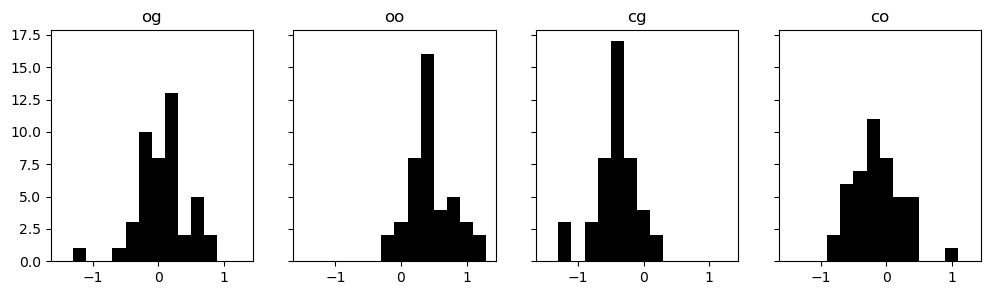

In [386]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 3), sharex=True, sharey=True)
bins = np.arange(-1.5, 1.5, 0.2)
for pos, i in zip(["og", "oo", "cg", "co"], range(4)):
    ax[i].hist(eudc_ests[f"{pos}_adj_est"], bins=bins, color="black")
    ax[i].set_title(pos)
plt.show()

In [418]:
def get_prior(position):
    xticks = np.round(np.arange(-2, 2, 0.01), decimals=2)
    mean = dict(zip(["og", "oo", "cg", "co"], [0.06, 0.49, -0.42, -0.13]))[position]
    stdev = 0.35
    exp_bit = np.exp(-(xticks - mean) ** 2 / (2 * stdev ** 2))
    adjustment = (1 / (2 * np.pi * stdev ** 2) ** 0.5)
    prior = pd.Series(adjustment * exp_bit, index=xticks)
    return prior / prior.sum()

# 6. Putting it all together

Now to import all the data from various past WUDCs. 

In [403]:
wudc_frames = []
for year in range(2019, 2026):
    year_frame = pd.read_csv(f"splits/wudc{year}.txt", sep=" ")
    year_frame["year"] = year
    wudc_frames.append(year_frame)
wudc_frame = pd.concat(wudc_frames)

In [414]:
def run_first_estimates(split_df):

    # Make predictors and responders
    block_a = pd.get_dummies(split_df["team_a"]).astype(int) - pd.get_dummies(split_df["team_b"]).astype(int)
    b_1 = pd.get_dummies(split_df["team_a_pos"] + split_df["round_num"].astype(str)).astype(int)
    b_2 = pd.get_dummies(split_df["team_b_pos"] + split_df["round_num"].astype(str)).astype(int)
    b1_aligned, b2_aligned = b_1.align(b_2, join='outer', axis=1, fill_value=0)
    block_b = b1_aligned - b2_aligned
    predictor_frame = pd.concat([block_a, block_b], axis=1).fillna(0) 
    # Necessary for if the team just does one round, e.g., swing team, sore losers
    responder_series = (split_df["team_a_rank"] < split_df["team_b_rank"]).astype(int)

    # Fit the model
    model = LogisticRegression(fit_intercept=False, penalty="l2", C=1)
    model.fit(predictor_frame, responder_series)
    coefficients = pd.Series(model.coef_[0], predictor_frame.columns)
    team_coefs = coefficients.iloc[:-36]
    bias_coefs = coefficients.iloc[-36:]

    # Get estimated bias
    internal_df = pd.DataFrame({
        "round": range(1, 10),
        "og_est": list(bias_coefs.iloc[18:27]),
        "oo_est": list(bias_coefs.iloc[27:36]),
        "cg_est": list(bias_coefs.iloc[0:9]),
        "co_est": list(bias_coefs.iloc[9:18])
    })

    
    # Add dispersion
    skill_dict = dict(zip(team_coefs.index, team_coefs))
    team_a_skills, team_b_skills = split_df["team_a"].map(skill_dict), split_df["team_b"].map(skill_dict)
    skill_splits = team_a_skills - team_b_skills
    round_skill_splits = {i: skill_splits[split_df["round_num"] == i] for i in range(1, 10)}
    internal_df["dispersion"] = [abs(round_skill_splits[i]).mean() for i in range(1, 10)]
    
    return internal_df 

In [423]:
# Get prior: get_prior(position)
# Get likelihood: get_full_likelihoods(estimate, position, dispersion)

def get_plp(year, round, position):
    year_df = run_first_estimates(wudc_frame[wudc_frame["year"] == year])
    round_row = year_df.iloc[round - 1]
    estimate = round_row[f"{position}_est"]
    dispersion = round_row["dispersion"]
    prior = get_prior(position)
    likelihood = get_full_likelihoods(estimate, position, dispersion)
    posterior = prior * likelihood / (prior * likelihood).sum()
    return prior, likelihood, posterior

In [430]:
def graph_plp(year, round, position):
    prior, likelihood, posterior = get_plp(year, round, position)
    fig, ax = plt.subplots()
    ax.plot(prior, color="green")
    ax.plot(likelihood, color="red")
    ax.plot(posterior, color="black")
    ax.legend(["prior", "likelihood", "posterior"])
    plt.show()

In [434]:
def get_posterior_mean(year, round, position):
    posterior = get_plp(year, round, position)[2]
    posterior_mean = (posterior.index * posterior).sum()
    return posterior_mean

In [435]:
def prob_motion_favourable(year, round, position):
    posterior = get_plp(year, round, position)[2]
    prob_above_zero = posterior[posterior.index > 0].sum()
    return prob_above_zero

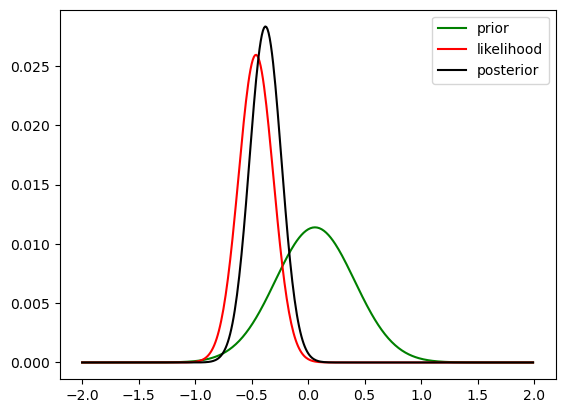

In [491]:
graph_plp(2024, 9, "og")

In [440]:
rows = []
for year in range(2019, 2026):
    for round in range(1, 10):
        row = [year, round]
        for position in ["og", "oo", "cg", "co"]:
            row.append(get_posterior_mean(year, round, position))
        rows.append(row)
posterior_mean_df = pd.DataFrame(rows, columns=["year", "round", "og", "oo", "cg", "co"])

In [446]:
rows = []
for year in range(2019, 2026):
    for round in range(1, 10):
        row = [year, round]
        for position in ["og", "oo", "cg", "co"]:
            row.append(prob_motion_favourable(year, round, position))
        rows.append(row)
prob_favourable_df = pd.DataFrame(rows, columns=["year", "round", "og", "oo", "cg", "co"])

In [489]:
with pd.option_context('display.float_format', '{:.3}'.format):
    display(prob_favourable_df.tail(9))

,year,round,og,oo,cg,co
54,2025,1,0.857,1.0,0.0123,0.00968
55,2025,2,0.0686,1.0,0.0477,0.0764
56,2025,3,1.0,0.0718,0.111,0.00114
57,2025,4,0.968,0.908,0.0116,0.15
58,2025,5,0.026,1.0,0.000118,0.985
59,2025,6,0.328,0.873,0.418,0.265
60,2025,7,0.0267,0.991,0.577,0.227
61,2025,8,0.36,0.994,0.00878,0.541
62,2025,9,0.841,1.0,0.0296,0.00155


In [463]:
with pd.option_context('display.float_format', '{:.3f}'.format):
    display(prob_favourable_df[posterior_mean_df["year"] == 2024])

,year,round,og,oo,cg,co
45,2024,1,0.247,1.000,0.000,0.633
46,2024,2,0.011,1.000,0.001,0.829
47,2024,3,0.094,0.990,0.111,0.519
48,2024,4,0.013,1.000,0.000,0.640
49,2024,5,0.257,1.000,0.041,0.061
50,2024,6,0.140,0.983,0.225,0.333
51,2024,7,0.964,0.392,0.892,0.002
52,2024,8,0.837,0.643,0.071,0.499
53,2024,9,0.003,0.999,0.105,0.692


Let's find the motion with the largest average effect. The measure I will use is the variance of the mean estimated effect size in a given round, i.e., taking all of the entries in posterior_mean_df, squaring them, and taking the sum. This is because, on the assumption of fairness, errors should be normally distributed, so taking the squared difference from 0 is a good penalty for unfairness. 

In [468]:
posterior_mean_df["penalty"] = (posterior_mean_df[["og", "oo", "cg", "co"]] ** 2).sum(axis=1)
with pd.option_context('display.float_format', '{:.3f}'.format):
    display(posterior_mean_df.sort_values(by="penalty", ascending=False).head(10))
    display(posterior_mean_df.sort_values(by="penalty", ascending=True).head(10))

,year,round,og,oo,cg,co,penalty
1,2019,2,-0.489,0.743,-0.653,0.398,1.375
36,2023,1,-0.202,0.997,-0.466,-0.333,1.363
56,2025,3,0.895,-0.225,-0.188,-0.476,1.114
48,2024,4,-0.334,0.818,-0.547,0.060,1.083
45,2024,1,-0.111,0.738,-0.690,0.063,1.036
34,2022,8,-0.368,0.678,-0.549,0.236,0.952
46,2024,2,-0.358,0.707,-0.507,0.156,0.909
42,2023,7,-0.368,0.606,-0.482,0.244,0.794
27,2022,1,-0.133,0.701,-0.437,-0.132,0.717
58,2025,5,-0.281,0.493,-0.536,0.324,0.714


,year,round,og,oo,cg,co,penalty
24,2021,7,0.094,0.079,-0.074,-0.099,0.030
59,2025,6,-0.060,0.173,-0.025,-0.087,0.042
31,2022,5,0.071,0.148,-0.090,-0.129,0.052
52,2024,8,0.146,0.057,-0.206,0.005,0.067
6,2019,7,-0.053,0.212,-0.137,-0.022,0.067
30,2022,4,0.083,0.132,-0.226,0.012,0.076
32,2022,6,0.197,0.069,-0.159,-0.107,0.080
4,2019,5,-0.234,0.168,0.021,0.045,0.085
18,2021,1,-0.158,0.220,-0.115,0.054,0.089
5,2019,6,-0.177,-0.002,-0.056,0.236,0.090


So our most biased motions are as follows:
* This House believes that the protections of international law conventions and treaties should not apply to combatants from terrorist organisations (e.g. prohibition on torture, prisoner of war status, guarantee of post-conflict release). (Biased against)
* A team that’s recently gained prominence after great performances at the World Cup has advanced to World Cup finals for the first time. After the semi final, the team's top scorer and most important player, while drunk at a bar, publicly instigated a physical fight against another member of the team. When asked to calm down they continued to double down, causing more of a public disruption and seemingly irreconcilable differences with other members of the team. This House believes that it's in the interest of the team for the player to be excluded from the World Cup finals squad. (Biased against)
* This House Believes that US involvement in Panama has benefitted Panama. (Biased in favour)
* This House supports the remilitarisation of Japan. (Biased against)
* This House believes that education systems should over-inflate children’s academic self-perception (e.g. providing overwhelmingly positive feedback, avoiding fail grades, etc.). (Biased against)

And the least biased motions are: 
* This House believes that pursuing strong expansionist policies in the Arctic region (including but not limited to: building artificial islands in order to claim additional territory, trying to significantly limit foreign presence, stationing warships and troops) is in the Russian interest.
* This House supports the rise of specialised private equity firms and funds that focus on specific sectors or geographies.
* This House opposes the emphasis on the struggle against the Ottoman Empire in the history curriculum of Balkan countries.
* This House believes that central banks should 'lean against the wind'.
* This House would actively encourage women not to have children

The very worst split is round 1 of 2023, unsurprisingly between OO and CG, where, if they are evenly matched, CG has a 19% chance of winning. In fact, if you take the 10 most biased motions, in 9 of them the best team to be is OO and the worst team to be is CG. 